In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import scipy.special as sp
import pickle
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
from sconce.utils import cart2sph, sph2cart
from sconce.FilaAttr import DetectKnot
from sconce.EucSCMS import KDE
from sconce.DirSCMS import DirKDE
from sconce.EucSCMS_RayFunc import MS_Ray, SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray, DirSCMSLog_Ray

import ray

In [3]:
from astropy.cosmology import WMAP9

print(WMAP9)

FlatLambdaCDM(name="WMAP9", H0=69.3 km / (Mpc s), Om0=0.286, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0463)


## Loading the pre-cleaned SDSS galaxy/QSO data

In [4]:
from astropy.io import fits
from astropy.table import Table

# with fits.open('Data/SDSSIV_gal_QSO_dat.fits') as hdulist:
#     SDSS_dat = Table.read(hdulist[1])
# SDSS_dat = SDSS_dat.to_pandas()
# SDSS_dat.head(5)

SDSS_dat = pd.read_csv('Data/SDSSIV_gal_QSO_dat_small.csv')
SDSS_dat.head(5)

,PLATE,MJD,FIBERID,RA,DEC,Z,total_mass
0,266,51602,6,146.96390,-0.545003,0.055988,3.357219e+07
1,266,51602,8,146.60721,-1.240753,0.090633,7.675995e+10
2,266,51602,10,146.72794,-0.556880,0.089337,3.745686e+10
3,266,51602,12,146.59272,-0.760256,0.065024,1.884939e+10
4,266,51602,15,146.94999,-0.592202,0.064777,8.659015e+08


## Application I: Subset a slice of the Universe in the low-redshift region ($0.05 \leq z < 0.055$)

We subset the SDSS_IV galaxies on the North Galactic Cap within this redshift slice, obtain their spherical mean $\frac{\sum_{i=1}^n \mathbf{X}_i}{||\sum_{i=1}^n \mathbf{X}_i||_2}$ on the celestial sphere based on their (RAs, DECs), and rotate the galaxies such that their new spherical mean is at the North Pole ($DEC=90^{\circ}$).

In [5]:
z_l = 0.05
z_h = 0.055
gal_slice = SDSS_dat[(SDSS_dat.Z >= z_l) & (SDSS_dat.Z < z_h)]
# Focus on the north galactic cap
gal_north = gal_slice[(gal_slice.RA > 100) & (gal_slice.RA < 270) & (gal_slice.DEC > -5) & (gal_slice.DEC < 70)]
X, Y, Z = sph2cart(*gal_north[['RA', 'DEC']].values.T)
gal_north_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
print(gal_north_cart.shape)

(22709, 3)


Prepare the data format of which the DisPerSE code can read: http://www2.iap.fr/users/sousbie/web/html/index744c.html?post/survey_ascii-format

In [6]:
from astropy.io import ascii

gal_north_ang = gal_north[['RA', 'DEC']]
gal_north_ang.columns = ['px', 'py']
dat_table = Table.from_pandas(gal_north_ang)

# Output the file for which the DisPerSE code can read: 2D angular coordinates indicated by columns 'px', 'py'.
ascii.write(dat_table, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005.survey_ascii', 
            overwrite=True, comment=False)

gal_north_cart_df = pd.DataFrame(gal_north_cart)
gal_north_cart_df.columns = ['px', 'py', 'pz']
dat_df = Table.from_pandas(gal_north_cart_df)

# Output the file for which the DisPerSE code can read: 3D Cartesian coordinates indicated by columns 'px', 'py', 'pz'.
ascii.write(dat_df, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.survey_ascii', 
            overwrite=True, comment=False)


gal_north_rs = gal_north[['RA', 'DEC', 'Z']]
gal_north_rs.columns = ['ra', 'dec', 'z']
dat_table_rs = Table.from_pandas(gal_north_rs)

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.survey_ascii', 
            overwrite=True, comment=False)

In [7]:
## Compute the spherical mean
gal_c = np.sum(gal_north_cart, axis=0)/LA.norm(np.sum(gal_north_cart, axis=0))
RA_c, DEC_c, R = cart2sph(*gal_c.T)
RA_c + 360, DEC_c

(187.38490518277337, 34.518334835200214)

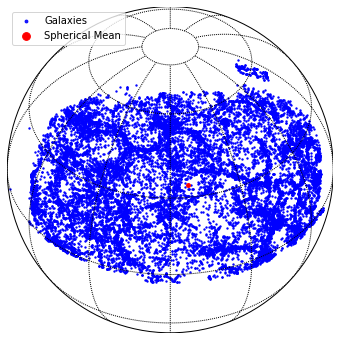

In [8]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_p = gal_north['RA']
lat_p = gal_north['DEC']
m1 = Basemap(projection='ortho', lon_0=180, lat_0=40, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_c, y_c = m1(RA_c+360, DEC_c)
cs = m1.scatter(x_p, y_p, color='blue', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_c, y_c, color='red', marker='o', s=15, label='Spherical Mean')
plt.legend(markerscale=2, loc='upper left')
# fig.tight_layout()
plt.show()

### Detecting the cosmic filaments before rotating the selected galaxies (i.e., in the original SDSS observational region with low declination)

##### (i) Standard SCMS and DirSCMS algorithms

In [9]:
# Bandwidth selection
data = gal_north_cart
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4

data = gal_north[['RA', 'DEC']].values
d = data.shape[1]
n = data.shape[0]
bw_Eu = 0.6*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))

# Thresholding
d_Eu_dat = KDE(gal_north[['RA', 'DEC']].values, gal_north[['RA', 'DEC']].values, h=bw_Eu)
tau = np.std(d_Eu_dat)
gal_north_ang = gal_north[['RA', 'DEC']].values
gal_north_ang_thres = gal_north_ang[d_Eu_dat >= tau,:]
if gal_north_ang_thres.shape[0]/gal_north_ang.shape[0] < 0.8:
    gal_north_ang_thres = gal_north_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
print("Euclidean Thresholding Ratio: "+str(gal_north_ang_thres.shape[0]/gal_north_ang.shape[0]))

d_Dir_dat = DirKDE(gal_north_cart, gal_north_cart, h=bw_Dir)
gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.std(d_Dir_dat)]
if gal_north_cart_thres.shape[0]/gal_north_cart.shape[0] < 0.8:
    gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_north_cart_thres.shape[0]/gal_north_cart.shape[0]))

Euclidean Thresholding Ratio: 0.7999911929191069
Directional Thresholding Ratio: 0.7999911929191069


In [10]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)
mesh1_Eu = np.concatenate([lon_m.reshape(-1,1), lat_m.reshape(-1,1)], axis=1)

d_m_Dir = DirKDE(mesh1, gal_north_cart_thres, h=bw_Dir)
mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))

d_m_Eu = KDE(mesh1_Eu, gal_north_ang_thres, h=bw_Eu)
mesh1_Eu_thres = mesh1_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_Eu_thres.shape[0]/mesh1_Eu.shape[0]))

Remaining mesh point ratio: 0.8499538319482918
Remaining mesh point ratio: 0.8499538319482918


In [13]:
# DMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-07 03:36:20,014	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [14]:
# MS
ray.init()
mesh_0 = mesh1_Eu_thres
dataset = gal_north_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-7, max_iter=5000))
EuMS_pts = ray.get(result_ids)
EuMS_pts = np.concatenate(EuMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org_h0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuMS_pts], file)

2022-07-07 03:37:50,356	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [15]:
# DirSCMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-07 03:44:58,032	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [18]:
# SCMS
ray.init()
mesh_0 = mesh1_Eu_thres
dataset = gal_north_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, max_iter=5000))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org_h0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuSCMS_pts], file)

2022-07-07 03:59:03,887	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


##### (ii) Run the DisPerSE code on the 2D angular coordinates of $\mathbb{S}^2$

In [19]:
!../../disperse/bin/delaunay_2D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005 -btype smooth


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.0219216 (actual size is ~3.64516).
Tesselating 22709 particles (2D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (136 guards):  tesselation ...  generating ... cleaning up ... done. (+1110 particles)
Adding 1110 particles ... done.
Computing density ... done.
All done in 0.05 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005.NDnet
   comment: 'No cosmological conversion.'
   2D-Network has 21799 vertices.
   periodicity: non-periodic.
   Available faces: 65034 1-F, 43234 2-F.
   Bounding box: x0=[100.026,-3.9225],
                 delta=[166.281,72.585].
   Available fields: 'fi

In [20]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005 -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005.NDnet'.
Loading 2D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005.NDnet" ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (460 1-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 130067 cells:
   Identifying (1,2)-cell pairs:
      Sorting 65034 1-cells (asc.) ... done.
      Computing MST ... (components) done.(663/43234 comp.)
      Computing discrete Gradient (663 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Computing MST ... (components) done.(3597/21799 comp.)
      Computing discrete Gradient (3597 comp.) ... done.
   Critical cells : 3597(+0) 0-cells, 4258(+4258) 1-cells, 663(+0) 2-cells.
Computing discrete Morse-Smale complex: 
    8518 critical points: 663 min, 4258 s1, 3597 max.
    *

In [21]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.NDskl'.
Loading 2D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 915(+104) nodes and 7765(-953) segments.
Assembling skeleton ... done. (found 252 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 409(-506) nodes and 7765(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 2D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.S005.BRK.ASMB.a.NDskl ... done.


##### (iii) Run the DisPerSE code under the Cartesian coordinates on $\mathbb{S}^2$

In [22]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart -btype mirror


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.113411 (actual size is ~0.220288).
Tesselating 22709 particles (3D) ... (+22235 in boundary)
         Some points have identical coordinates !
 done. (0.42s elapsed)
Identifying boundaries ... done.
Adding 66164 guard particles ... 
         Some points have identical coordinates !
 done. (1.73s elapsed)
Identifying boundaries ... done.
Adding 421716 guard particles ... 
         Some points have identical coordinates !
 done. (6.41s elapsed)
Identifying boundaries ... done.
Adding 106929 guard particles ... 
         Some points have identical coordinates !
 done. (8.07s elapsed)
Identifying boundaries ... done.
Computing density ... done.
All done in 8.93 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal

In [23]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (47808 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 1330133 cells:
   Identifying (2,3)-cell pairs:
      Sorting 617831 2-cells (asc.) ... done.
      Computing MST ... (components) done.(2206/258371 comp.)
      Computing discrete Gradient (2206 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 389662 1-cells (desc.) ... done.
      Computing MST ... (components) done.(3362/64269 comp.)
      Computing discrete Gradient (3362 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG 

In [24]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 6636(+-882) nodes and 16440(-4401) segments.
Assembling skeleton ... done. (found 1406 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 2318(-4318) nodes and 16431(-9) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.S005.BRK.ASMB.a.NDskl ... done.


##### (iv) Run the DisPerSE code on the 3D (ra, dec, redshift) space under the WMAP-9 cosmology

In [25]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.116176 (actual size is ~50.8083).
Tesselating 22709 particles (3D) ... (+0 in boundary) done. (0.14s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (312 guards):  tesselation ...  generating ... cleaning up ... done. (+103756 particles)
Adding 103756 particles ... done.
Computing density ... done.
All done in 1.45 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 31050 vertices.
   periodicity: non-periodic.
   Available faces: 220418 1-F, 370841 2-F, 174185 3-F.
   Bounding box: x0=[-235.523,-218.917,-17.3199]

In [26]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (23443 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 796494 cells:
   Identifying (2,3)-cell pairs:
      Sorting 370841 2-cells (asc.) ... done.
      Computing MST ... (components) done.(435/174185 comp.)
      Computing discrete Gradient (435 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 220418 1-cells (desc.) ... done.
      Computing MST ... (components) done.(9000/31050 comp.)
      Computing discrete Gradient (9000 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ... don

In [27]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up \
-smooth 5 -breakdown -assemble 75 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 3445(+292) nodes and 11857(-3918) segments.
Assembling skeleton ... done. (found 1295 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 1737(-1708) nodes and 11756(-101) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


### Detecting the cosmic filaments after rotating the selected galaxies to the regions with high declination (i.e., centering at the North pole)

In [11]:
## Compute the spherical mean
gal_c = np.sum(gal_north_cart, axis=0)/LA.norm(np.sum(gal_north_cart, axis=0))
RA_c, DEC_c, R = cart2sph(*gal_c.T)
RA_c + 360, DEC_c

(187.38490518277337, 34.518334835200214)

In [12]:
## Rotate the data samples accordingly
pv_ax = np.array([[0,0,1]])
gal_c = gal_c.reshape(1, 3)
R_mat = 2*np.dot(pv_ax.T + gal_c.T, pv_ax + gal_c)/np.sum((gal_c+pv_ax)**2, axis=1) - np.identity(3)
gal_north_rot = np.dot(R_mat, gal_north_cart.T).T
RA_r, DEC_r, R = cart2sph(*gal_north_rot.T)
RA_r[(RA_r >= -180) & (RA_r <= 0)] = RA_r[(RA_r >= -180) & (RA_r <= 0)] + 360
gal_north_rot_ang = np.concatenate([RA_r.reshape(-1,1), DEC_r.reshape(-1,1)], axis=1)

gal_north_rot_df = pd.DataFrame({'ra': RA_r, 'dec': DEC_r, 'z': gal_north.Z.values})

In [26]:
# Output the data after rotation
gal_north_rot_df[['px', 'py']] = gal_north_rot_df[['ra', 'dec']]
dat_table = Table.from_pandas(gal_north_rot_df[['px', 'py']])

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.survey_ascii', 
            overwrite=True, comment=False)

gal_north_rot_cart_df = pd.DataFrame(gal_north_rot)
gal_north_rot_cart_df.columns = ['px', 'py', 'pz']
dat_table_cart = Table.from_pandas(gal_north_rot_cart_df)

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_cart, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.survey_ascii', 
            overwrite=True, comment=False)

dat_table_rs = Table.from_pandas(gal_north_rot_df[['ra', 'dec', 'z']])

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.survey_ascii', 
            overwrite=True, comment=False)

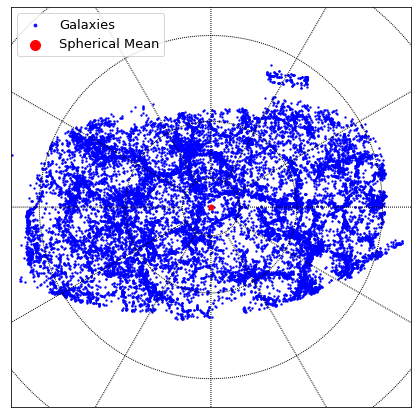

In [13]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_c, y_c = m1(0, 90)
cs = m1.scatter(x_p, y_p, color='blue', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_c, y_c, color='red', marker='o', s=25, label='Spherical Mean')
plt.legend(markerscale=2, loc='upper left')
fig.tight_layout()
plt.show()

##### (i) Standard SCMS and DirSCMS algorithms (at the North pole)

In [14]:
# Bandwidth selection (using the same choice of bandwidth parameter as the data are in low-DEC regions)
data = gal_north_rot
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4

data = gal_north_ang
d = data.shape[1]
n = data.shape[0]
bw_Eu = 0.6*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))

# Thresholding
d_Eu_dat = KDE(gal_north_rot_ang, gal_north_rot_ang, h=bw_Eu)
tau = np.std(d_Eu_dat)
gal_north_rot_ang_thres = gal_north_rot_ang[d_Eu_dat >= tau,:]
if gal_north_rot_ang_thres.shape[0]/gal_north_rot_ang.shape[0] < 0.8:
    gal_north_rot_ang_thres = gal_north_rot_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
print("Euclidean Thresholding Ratio: "+str(gal_north_rot_ang_thres.shape[0]/gal_north_rot_ang.shape[0]))

d_Dir_dat = DirKDE(gal_north_rot, gal_north_rot, h=bw_Dir)
rho_Dir = 1
gal_north_rot_thres = gal_north_rot[d_Dir_dat >= rho_Dir*np.std(d_Dir_dat)]
if gal_north_rot_thres.shape[0]/gal_north_rot.shape[0] < 0.8:
    gal_north_rot_thres = gal_north_rot[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_north_rot_thres.shape[0]/gal_north_rot.shape[0]))

Euclidean Thresholding Ratio: 0.7999911929191069
Directional Thresholding Ratio: 0.7999911929191069


In [15]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)
mesh1_rot = np.dot(R_mat, mesh1.T).T
lon_r, lat_r, R = cart2sph(*mesh1_rot.T)
lon_r[(lon_r >= -180) & (lon_r <= 0)] = lon_r[(lon_r >= -180) & (lon_r <= 0)] + 360
mesh1_rot_Eu = np.concatenate([lon_r.reshape(-1,1), lat_r.reshape(-1,1)], axis=1)

d_m_Dir = DirKDE(mesh1_rot, gal_north_rot_thres, h=bw_Dir)
mesh1_rot_thres = mesh1_rot[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_rot_thres.shape[0]/mesh1_rot.shape[0]))

d_m_Eu = KDE(mesh1_rot_Eu, gal_north_rot_ang_thres, h=bw_Eu)
mesh1_rot_Eu_thres = mesh1_rot_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_rot_Eu_thres.shape[0]/mesh1_rot_Eu.shape[0]))

Remaining mesh point ratio: 0.8499538319482918
Remaining mesh point ratio: 0.8499538319482918


In [20]:
# DMS
ray.init()
mesh_0 = mesh1_rot_thres
dataset = gal_north_rot_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-15 02:29:15,350	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [21]:
# MS
ray.init()
mesh_0 = mesh1_rot_Eu_thres
dataset = gal_north_rot_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-7, max_iter=5000))
EuMS_pts = ray.get(result_ids)
EuMS_pts = np.concatenate(EuMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuMS_pts], file)

2022-07-15 02:30:53,037	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [22]:
# DirSCMS
ray.init()
mesh_0 = mesh1_rot_thres
dataset = gal_north_rot_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-15 02:39:39,024	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [25]:
# SCMS
ray.init()
mesh_0 = mesh1_rot_Eu_thres
dataset = gal_north_rot_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, max_iter=5000))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuSCMS_pts], file)

2022-07-15 02:54:19,096	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


#### (ii) Run the DisPerSE code on the 2D angular coordinates of $\mathbb{S}^2$ (at the North pole)

In [27]:
!../../disperse/bin/delaunay_2D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole -btype smooth


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.0163303 (actual size is ~5.88538).
Tesselating 22709 particles (2D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (158 guards):  tesselation ...  generating ... cleaning up ... done. (+2047 particles)
Adding 2047 particles ... done.
Computing density ... done.
All done in 0.04 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.NDnet
   comment: 'No cosmological conversion.'
   2D-Network has 21848 vertices.
   periodicity: non-periodic.
   Available faces: 65131 1-F, 43282 2-F.
   Bounding box: x0=[-0.208965,1.96963],
                 delta=[360.39

In [28]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.NDnet'.
Loading 2D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole.NDnet" ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (573 1-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 130261 cells:
   Identifying (1,2)-cell pairs:
      Sorting 65131 1-cells (asc.) ... done.
      Computing MST ... (components) done.(683/43282 comp.)
      Computing discrete Gradient (683 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Computing MST ... (components) done.(3657/21848 comp.)
      Computing discrete Gradient (3657 comp.) ... done.
   Critical cells : 3657(+0) 0-cells, 4339(+4339) 1-cells, 683(+0) 2-cells.
Computing discrete Morse-Smale complex: 
    8679 critical points: 683 min, 43

In [29]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.NDskl'.
Loading 2D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 899(+114) nodes and 7641(-1216) segments.
Assembling skeleton ... done. (found 243 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 389(-510) nodes and 7641(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 2D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iii) Run the DisPerSE code under the Cartesian coordinates of $\mathbb{S}^2$ (at the North pole)

In [30]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart -btype mirror


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.126891 (actual size is ~0.243986).
Tesselating 22709 particles (3D) ... (+22387 in boundary)
         Some points have identical coordinates !
 done. (0.40s elapsed)
Identifying boundaries ... done.
Adding 63158 guard particles ... 
         Some points have identical coordinates !
 done. (1.39s elapsed)
Identifying boundaries ... done.
Adding 458684 guard particles ... 
         Some points have identical coordinates !
 done. (6.81s elapsed)
Identifying boundaries ... done.
Computing density ... done.
All done in 7.71 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 63954 vertices.
   periodicity:

In [31]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (48454 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 1360157 cells:
   Identifying (2,3)-cell pairs:
      Sorting 640569 2-cells (asc.) ... done.
      Computing MST ... (components) done.(2491/257511 comp.)
      Computing discrete Gradient (2491 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 398123 1-cells (desc.) ... done.
      Computing MST ... (components) done.(3450/63954 comp.)
      Computing discrete Gradient (3450 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Compu

In [32]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 6948(+-1034) nodes and 16461(-4033) segments.
Assembling skeleton ... done. (found 1456 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 2395(-4553) nodes and 16411(-50) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iv) Run the DisPerSE code on the 3D (ra, dec, redshift) space with WMAP-9 cosmology (at the North pole)

In [33]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.survey_ascii (ASCII) ... done. (22709 lines)
Margin set to 0.129244 (actual size is ~55.9299).
Tesselating 22709 particles (3D) ... (+0 in boundary) done. (0.14s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (318 guards):  tesselation ...  generating ... cleaning up ... done. (+97559 particles)
Adding 97559 particles ... done.
Computing density ... done.
All done in 1.34 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 30741 vertices.
   periodicity: non-periodic.
   Available faces: 218691 1-F, 368386 2-F, 173280 3-F.
   Bounding box: 

In [34]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (22982 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 791098 cells:
   Identifying (2,3)-cell pairs:
      Sorting 368386 2-cells (asc.) ... done.
      Computing MST ... (components) done.(430/173280 comp.)
      Computing discrete Gradient (430 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 218691 1-cells (desc.) ... done.
      Computing MST ... (components) done.(8975/30741 comp.)
      Computing discrete Gradient (8975 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing sa

In [35]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up \
-smooth 5 -breakdown -assemble 75 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 3437(+294) nodes and 11918(-3913) segments.
Assembling skeleton ... done. (found 1307 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 1747(-1690) nodes and 11779(-139) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


### Uncertainty measure with Nonparametric Bootstrap

In [37]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "rb") as file:
    bw_Dir, DirModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuFila = pickle.load(file)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

B = 100  ## Number of bootstrapping times
start = time.time()
np.random.seed(123) 
boot_fila_Dir = []
boot_fila_Eu = []
for b in range(B):
    # Bootstrap
    rand_ind = np.random.choice(range(gal_north_rot.shape[0]), gal_north_rot.shape[0], replace=True)
    boot_dat_cart = gal_north_rot[rand_ind]
    boot_dat_ang = gal_north_rot_ang[rand_ind]
    
    # Bandwidth selection
    print(bw_Dir)
    print(bw_Eu)
    
    # Thresholding
    d_Eu_dat = KDE(boot_dat_ang, boot_dat_ang, h=bw_Eu)
    tau = np.std(d_Eu_dat)
    boot_dat_ang_thres = boot_dat_ang[d_Eu_dat >= tau,:]
    if boot_dat_ang_thres.shape[0]/boot_dat_ang.shape[0] < 0.8:
        boot_dat_ang_thres = boot_dat_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
    print("Euclidean Thresholding Ratio: "+str(boot_dat_ang_thres.shape[0]/boot_dat_ang.shape[0]))
    
    d_Dir_dat = DirKDE(boot_dat_cart, boot_dat_cart, h=bw_Dir)
    boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.std(d_Dir_dat)]
    if boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0] < 0.8:
        boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
    print("Directional Thresholding Ratio: "+str(boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0]))
    
    nrows, ncols = (76, 171)
    lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    
    mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                            yg.reshape(nrows*ncols, 1),
                            zg.reshape(nrows*ncols, 1)), axis=1)
    mesh1_rot = np.dot(R_mat, mesh1.T).T
    lon_r, lat_r, R = cart2sph(*mesh1_rot.T)
    lon_r[(lon_r >= -180) & (lon_r <= 0)] = lon_r[(lon_r >= -180) & (lon_r <= 0)] + 360
    mesh1_rot_Eu = np.concatenate([lon_r.reshape(-1,1), lat_r.reshape(-1,1)], axis=1)

    d_m_Dir = DirKDE(mesh1_rot, boot_dat_cart_thres, h=bw_Dir)
    mesh1_rot_thres = mesh1_rot[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_rot_thres.shape[0]/mesh1_rot.shape[0]))
    
    d_m_Eu = KDE(mesh1_rot_Eu, boot_dat_ang_thres, h=bw_Eu)
    mesh1_rot_Eu_thres = mesh1_rot_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_rot_Eu_thres.shape[0]/mesh1_rot_Eu.shape[0]))
    
    # DirSCMS
    ray.init()
    mesh_0 = mesh1_rot_thres
    dataset = boot_dat_cart_thres
    BW = bw_Dir
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                                eps=1e-7, max_iter=5000))
    DirSCMS_pts = ray.get(result_ids)
    DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
    # ray.shutdown()
    boot_fila_Dir.append(DirSCMS_pts)
    
    # SCMS
    mesh_0 = mesh1_rot_Eu_thres
    dataset = boot_dat_ang_thres
    BW = bw_Eu
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                             eps=1e-7, max_iter=5000))
    EuSCMS_pts = ray.get(result_ids)
    EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
    ray.shutdown()
    boot_fila_Eu.append(EuSCMS_pts)

with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "wb") as file:
    pickle.dump(boot_fila_Dir, file)
with open("./Data_Outputs/SDSS_Data/Boot_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "wb") as file:
        pickle.dump(boot_fila_Eu, file)
              
print("Elasped time: "+ str(time.time()-start)+'s.\n')

In [38]:
B = 100
with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "rb") as file:
    boot_fila_Dir = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Boot_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "rb") as file:
    boot_fila_Eu = pickle.load(file)

In [39]:
@ray.remote
def UncMsDir_Fs(fila, boot_fila):
    unc_arr = np.zeros((fila.shape[0], ))
    for i in range(fila.shape[0]):
        pt = fila[i,:]
        dist_sq = np.zeros((len(boot_fila), ))
        for j in range(len(boot_fila)):
            cir_inner = np.dot(boot_fila[j], pt)
            cir_inner[cir_inner > 1] = 1
            cir_inner[cir_inner < -1] = -1
            dist_sq[j] = min(np.arccos(cir_inner)**2)
        unc_arr[i] = np.sqrt(np.mean(dist_sq))
    return unc_arr

@ray.remote
def UncMsEu_Fs(fila, boot_fila):
    unc_arr = np.zeros((fila.shape[0], ))
    for i in range(fila.shape[0]):
        pt = fila[i,:]
        dist_sq = np.zeros((len(boot_fila), ))
        for j in range(len(boot_fila)):
            dist_sq[j] = min(LA.norm(boot_fila[j] - pt, axis=1)**2)
        unc_arr[i] = np.sqrt(np.mean(dist_sq))
    return unc_arr

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

ray.init()
chunksize = 10
fila_data = DirFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsDir_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Dir))
unc_Dir = ray.get(result_ids)
unc_Dir = np.concatenate(unc_Dir, axis=0)
ray.shutdown()

ray.init()
chunksize = 10
fila_data = EuFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsEu_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Eu))
unc_Eu = ray.get(result_ids)
unc_Eu = np.concatenate(unc_Eu, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "wb") as file:
    pickle.dump(unc_Dir, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump(unc_Eu, file)

In [40]:
with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    unc_Dir = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    unc_Eu = pickle.load(file)

In [42]:
import healpy as hp

def Mask_Filter(gal_RAs, gal_DECs, fil_RAs, fil_DECs, threshold=10, n_neigh=2, final_nside=256):
    nside = 32
    ## hp.nside2npix(nside) is equal to 12*nside**2
    healpix = np.zeros(hp.nside2npix(nside))
    gal_pix = hp.ang2pix(nside, theta=gal_RAs, phi=gal_DECs, lonlat=True)
    pix_ind, obs_cnt = np.unique(gal_pix, return_counts=True)
    healpix[pix_ind] = obs_cnt
    isolon, isolat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))[healpix > threshold], lonlat=True)
    
    # Set up the pixels and find their neighbors after thresholding
    nside_ne = 128
    healpix_ne = np.zeros(hp.nside2npix(nside_ne))
    ne_pix = hp.ang2pix(nside_ne, theta=isolon, phi=isolat, lonlat=True)
    for _ in range(n_neigh):
        ne_pix = np.unique(hp.get_all_neighbours(nside_ne, ne_pix))
    healpix_ne[ne_pix] = 1.
    healpix_ne = hp.ud_grade(healpix_ne, final_nside)
    
    fila_pix = hp.ang2pix(final_nside, theta=fil_RAs, phi=fil_DECs, lonlat=True)
    return healpix_ne, fila_pix

In [43]:
lon_f, lat_f, R = cart2sph(*DirFila.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], gal_DECs=gal_north_rot_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=1, 
                                        n_neigh=1, final_nside=32)
DirFila1 = DirFila[mask_pix_Dir[fil_pix_Dir] != 0]
unc_Dir1 = unc_Dir[mask_pix_Dir[fil_pix_Dir] != 0]

lon_m, lat_m, R = cart2sph(*DirModes.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)
DirModes1 = DirModes[mask_pix_Dir[mode_pix_Dir] != 0]

mask_pix_Eu, fil_pix_Eu = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], gal_DECs=gal_north_rot_ang[:,1], 
                                      fil_RAs=360-EuFila[:,0], fil_DECs=EuFila[:,1], 
                                      threshold=1, n_neigh=1, final_nside=32)
EuFila1 = EuFila[mask_pix_Eu[fil_pix_Eu] != 0]
unc_Eu1 = unc_Eu[mask_pix_Eu[fil_pix_Eu] != 0]

mode_pix_Eu = hp.ang2pix(32, theta=360-EuModes[:,0], phi=EuModes[:,1], lonlat=True)
EuModes1 = EuModes[mask_pix_Eu[mode_pix_Eu] != 0]

In [45]:
Knot_lab_Dir = pd.DataFrame(DirFila1).apply(lambda x: DetectKnot(x, r_in=2*bw_Dir/3, r_out=4*bw_Dir/3, 
                                                                fila_map=DirFila1), axis=1)
Knot_lab_Eu = pd.DataFrame(EuFila1).apply(lambda x: DetectKnot(x, r_in=2*bw_Eu/3, r_out=4*bw_Eu/3, 
                                                                fila_map=EuFila1), axis=1)

lon_c = np.linspace(0, 360, 200)
lat_c = 65*np.ones(200,)

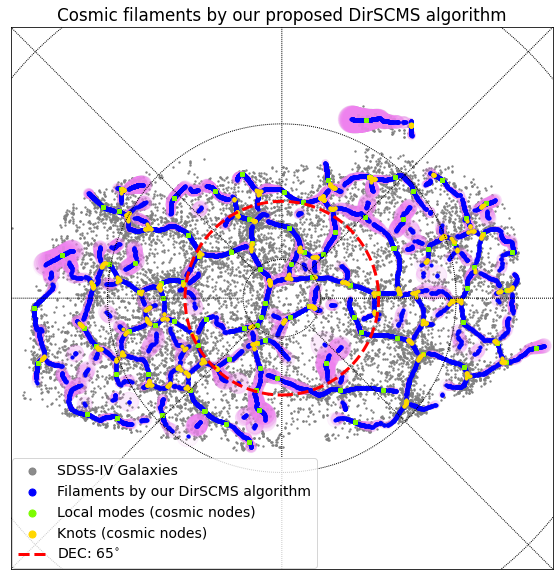

In [46]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes1.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila1.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 45))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='SDSS-IV Galaxies')
cs = m1.scatter(x_f, y_f, color='violet', s=(8e3)*unc_Dir1, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='blue', marker='o', s=10, label='Filaments by our DirSCMS algorithm')
# cs = m1.scatter(x_f, y_f, c=unc_Dir1*180/np.pi, s=8, cmap='winter')
cs = m1.scatter(x_m, y_m, color='lawngreen', marker='o', s=13, label='Local modes (cosmic nodes)')
cs = m1.scatter(x_f[Knot_lab_Dir == 'Knot'], y_f[Knot_lab_Dir == 'Knot'], color='gold', 
                marker='o', s=10, label='Knots (cosmic nodes)')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by our proposed DirSCMS algorithm')
plt.savefig('./Figures/DirSCMS_high_dec.jpg', bbox_inches="tight", dpi=150)

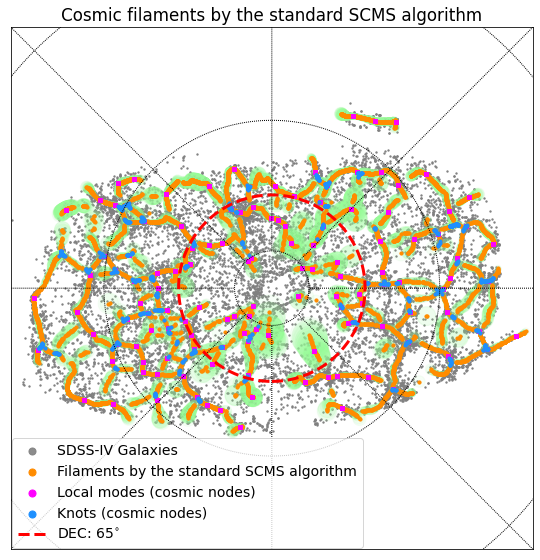

In [47]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_m = EuModes1[:,0]
lat_m = EuModes1[:,1]
lon_f = EuFila1[:,0]
lat_f = EuFila1[:,1]
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 45))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
## Color: 'lemonchiffon', 'peru', 'green', 'turquoise'
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='SDSS-IV Galaxies')
cs = m1.scatter(x_f, y_f, color='palegreen', s=(8e3)*unc_Eu1/180*np.pi, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='darkorange', marker='o', s=10, label='Filaments by the standard SCMS algorithm')
cs = m1.scatter(x_m, y_m, color='magenta', marker='o', s=16, label='Local modes (cosmic nodes)')
cs = m1.scatter(x_f[Knot_lab_Eu == 'Knot'], y_f[Knot_lab_Eu == 'Knot'], color='dodgerblue', 
                marker='o', s=10, label='Knots (cosmic nodes)')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
plt.title('Cosmic filaments by the standard SCMS algorithm')
plt.tight_layout()
plt.savefig('./Figures/EuSCMS_high_dec.jpg', bbox_inches="tight", dpi=150)

In [49]:
def read_skl(file, dim=3):
    i = 3
    line = 'start'
    while line != '[FILAMENTS]':
        line = np.loadtxt(file, skiprows=i, max_rows=1, usecols=0, dtype=str)
        i += 1
        
    n_fil = int(np.loadtxt(file, skiprows=i, max_rows=1, dtype=int))
    
    fil_id = np.zeros(0, dtype=int)
    fil_tracers = np.empty(shape=(0,dim), dtype=float)
    count = 1
    for j in range(n_fil):
        n_tracers = int(np.loadtxt(file, skiprows=i+1, max_rows=1, usecols=2, dtype=int))
        filament = np.loadtxt(file, skiprows=i+2, max_rows=n_tracers)
        fil_tracers = np.vstack([fil_tracers, filament])
        fil_id = np.append(fil_id, count*np.ones(n_tracers, dtype=int))
        count += 1
        i += n_tracers + 1
    
    return(n_fil, fil_id, fil_tracers)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

import os
disp_fil, fil_id, disp_web_rot = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
disp_fil, fil_id, disp_web_rot3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)

np.random.seed(123)
B = 100
unc_ang = np.zeros((B, disp_web_rot.shape[0]))
unc_3D = np.zeros((B, disp_web_rot3D.shape[0]))
unc_cart = np.zeros((B, disp_web_rot_cart.shape[0]))
for b in range(B):
    print(b)
    # Bootstrap
    rand_ind = np.random.choice(range(gal_north_rot.shape[0]), gal_north_rot.shape[0], replace=True)
    boot_dat_cart = gal_north_rot[rand_ind]
    boot_dat_ang = gal_north_rot_ang[rand_ind]
    boot_dat_rs = gal_north_rot_df.iloc[rand_ind].reset_index()
    
    dat_ang = pd.DataFrame(boot_dat_ang)
    dat_ang.columns = ['px', 'py']
    dat_ang = Table.from_pandas(dat_ang)
    # Output the file for which the DisPerSE code can read.
    ascii.write(dat_ang, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'.survey_ascii', overwrite=True, comment=False)
    
    dat_cart = pd.DataFrame(boot_dat_cart)
    dat_cart.columns = ['px', 'py', 'pz']
    dat_cart = Table.from_pandas(dat_cart)
    ascii.write(dat_cart, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart.survey_ascii', overwrite=True, comment=False)
    
    dat_table_rs = Table.from_pandas(boot_dat_rs[['ra', 'dec', 'z']])
    ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs.survey_ascii', 
            overwrite=True, comment=False)
    
    # 2D Angular (ra,dec) coordinate on S^2 
    os.system('../../disperse/bin/delaunay_2D '\
              './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+' -btype smooth')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+\
              ' -periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_s3.up '\
              '-smooth 5 -breakdown -assemble 75 -to NDskl_ascii')
    
    # 3D Cartesian coordinate on S^2
    os.system('../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart -btype mirror')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart '\
              '-periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_cart_s3.up '\
              '-smooth 5 -breakdown -assemble 75 -to NDskl_ascii')
    
    # 3D (ra,dec,z) coordinate
    os.system('../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs '\
              '-btype smooth -cosmo 0.286 0.714 0.00 0.693 -1.00')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs '\
              '-periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+'_rs_s3.up '\
              '-smooth 5 -breakdown -assemble 75 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii')
    
    
    disp_fil, fil_id, disp_ang_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+\
                                               '_s3.up.S005.BRK.ASMB.a.NDskl', dim=2)
    for i in range(disp_web_rot.shape[0]):
        unc_ang[b,i] = min(LA.norm(disp_ang_boot - disp_web_rot[i,:], axis=1)**2)
    
    disp_fil, fil_id, disp_cart_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+\
                                                '_cart_s3.up.S005.BRK.ASMB.a.NDskl', dim=3)
    inn_prod = np.dot(disp_web_rot_cart, disp_cart_boot.T)
    inn_prod[inn_prod > 1] = 1
    inn_prod[inn_prod < -1] = -1
    unc_cart[b,:] = np.min(np.arccos()**2, axis=1)
    
    disp_fil, fil_id, disp_3Drs_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z005_B'+str(b)+\
                                                '_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', dim=3)
    for i in range(disp_web_rot3D.shape[0]):
        unc_3D[b,i] = min(LA.norm(disp_3Drs_boot[:,:2] - disp_web_rot3D[i,:2], axis=1)**2)
    
unc_ang1 = np.sqrt(np.mean(unc_ang, axis=0))
unc_cart1 = np.sqrt(np.mean(unc_cart, axis=0))
unc_3D1 = np.sqrt(np.mean(unc_3D, axis=0))

with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"ang_north_pole.dat", "wb") as file:
    pickle.dump(unc_ang1, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"cart_north_pole.dat", "wb") as file:
    pickle.dump(unc_cart1, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"rs_north_pole.dat", "wb") as file:
    pickle.dump(unc_3D1, file)

In [51]:
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"ang_north_pole.dat", "rb") as file:
    unc_ang1 = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"cart_north_pole.dat", "rb") as file:
    unc_cart1 = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"rs_north_pole.dat", "rb") as file:
    unc_3D1 = pickle.load(file)

In [54]:
disp_fil, fil_id, disp_web_rot = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
dis_fila_rot = pd.DataFrame(disp_web_rot)
dis_fila_rot.columns = ['RA', 'DEC']

disp_fil, fil_id, disp_web_rot3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
dis_fila_rot_3D = pd.DataFrame(disp_web_rot3D)
dis_fila_rot_3D.columns = ['RA', 'DEC', 'Z']

disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)
lon_f, lat_f, R = cart2sph(*disp_web_rot_cart.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
dis_fila_rot_cart = pd.DataFrame({'RA': lon_f, 'DEC': lat_f})

In [56]:
mask_pix_disp_rot, fil_pix_disp_rot = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                  gal_DECs=gal_north_rot_ang[:,1], 
                                                  fil_RAs=360-dis_fila_rot['RA'].values, 
                                                  fil_DECs=dis_fila_rot['DEC'].values, 
                                                  threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot = dis_fila_rot[mask_pix_disp_rot[fil_pix_disp_rot] != 0]
unc_ang2 = unc_ang1[mask_pix_disp_rot[fil_pix_disp_rot] != 0]

mask_pix_disp_rot_3D, fil_pix_disp_rot_3D = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                      gal_DECs=gal_north_rot_ang[:,1], 
                                                      fil_RAs=360-dis_fila_rot_3D['RA'].values, 
                                                      fil_DECs=dis_fila_rot_3D['DEC'].values, 
                                                      threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot_3D = dis_fila_rot_3D[mask_pix_disp_rot_3D[fil_pix_disp_rot_3D] != 0]
unc_3D2 = unc_3D1[mask_pix_disp_rot_3D[fil_pix_disp_rot_3D] != 0]

mask_pix_disp_rot_cart, fil_pix_disp_rot_cart = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                      gal_DECs=gal_north_rot_ang[:,1], 
                                                      fil_RAs=360-dis_fila_rot_cart['RA'].values, 
                                                      fil_DECs=dis_fila_rot_cart['DEC'].values, 
                                                      threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot_cart = dis_fila_rot_cart[mask_pix_disp_rot_cart[fil_pix_disp_rot_cart] != 0]
unc_cart2 = unc_cart1[mask_pix_disp_rot_cart[fil_pix_disp_rot_cart] != 0]

lon_c = np.linspace(0, 360, 200)
lat_c = 65*np.ones(200,)

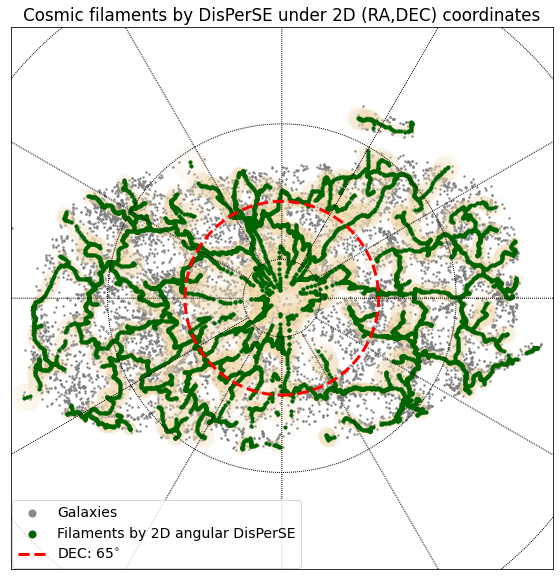

In [57]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_f = dis_fila_rot['RA'].values
lat_f = dis_fila_rot['DEC'].values
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='wheat', s=(8e3)*unc_ang2/180*np.pi, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='darkgreen', marker='o', s=10, label='Filaments by 2D angular DisPerSE')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by DisPerSE under 2D (RA,DEC) coordinates')
plt.savefig('./Figures/Disperse_ang_high_dec.jpg', bbox_inches="tight", dpi=150)

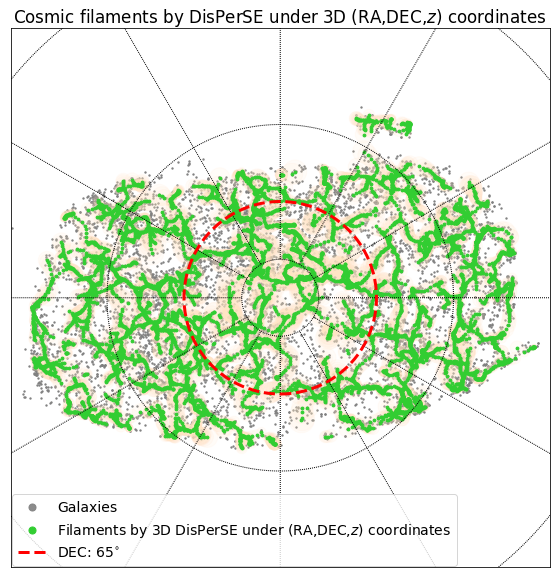

In [58]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_f = dis_fila_rot_3D['RA'].values
lat_f = dis_fila_rot_3D['DEC'].values
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='bisque', s=(8e3)*unc_3D2/180*np.pi, alpha=0.1)
cs = m1.scatter(x_f, y_f, color='limegreen', marker='o', s=8, label='Filaments by 3D DisPerSE under (RA,DEC,$z$) coordinates')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by DisPerSE under 3D (RA,DEC,$z$) coordinates')
plt.savefig('./Figures/Disperse_rs_high_dec.jpg', bbox_inches="tight", dpi=150)

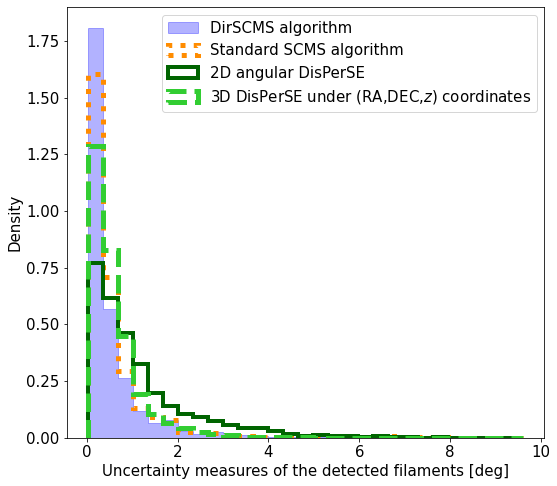

In [59]:
bins_ed = np.linspace(min(unc_Dir1*180/np.pi), max(unc_Eu1), 30)
alp = 1

plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
plt.figure(figsize=(8,7))
# Histogram comparisons
plt.hist(unc_Dir1*180/np.pi, bins=bins_ed, histtype='step', alpha=0.3, fill=True, density=True, color='blue',
         label='DirSCMS algorithm')
plt.hist(unc_Eu1, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='darkorange', 
         linewidth=5, linestyle='dotted', label='Standard SCMS algorithm')
plt.hist(unc_ang2, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='darkgreen', 
         linewidth=4, label='2D angular DisPerSE')
# plt.hist(unc_cart2*180/np.pi, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, 
#          label='3D Cartesian DisPerSE on $\mathbb{S}^2$')
plt.hist(unc_3D2, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='limegreen',
         linewidth=5, linestyle='dashed', label='3D DisPerSE under (RA,DEC,$z$) coordinates')
plt.legend()
plt.xlabel('Uncertainty measures of the detected filaments [deg]')
plt.ylabel('Density')
plt.tight_layout()
# plt.show()
plt.savefig('./Figures/Unc_compare_high_dec.pdf', bbox_inches="tight")

### Comparing the detected filaments by different methods when the data are in low-DEC and high-DEC regions

In [61]:
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org.dat", "rb") as file:
    bw_Dir, DirFila_org = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org_h0.6.dat", "rb") as file:
    bw_Eu, EuFila_org = pickle.load(file)
    
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuFila = pickle.load(file)

Rotate the detected filaments from low-DEC regions to high-DEC ones accordingly

In [62]:
pv_ax = np.array([[0,0,1]])
gal_c = gal_c.reshape(1, 3)
R_mat = 2*np.dot(pv_ax.T + gal_c.T, pv_ax + gal_c)/np.sum((gal_c+pv_ax)**2, axis=1) - np.identity(3)
DirFila_org_rot = np.dot(R_mat, DirFila_org.T).T

X_f, Y_f, Z_f = sph2cart(*EuFila_org.T)
EuFila_org_cart = np.vstack((X_f, Y_f, Z_f)).T
EuFila_org_rot = np.dot(R_mat, EuFila_org_cart.T).T
# RA_f, DEC_f, R = cart2sph(*EuFila_rot.T)
# RA_f[(RA_f >= -180) & (RA_f <= 0)] = RA_f[(RA_f >= -180) & (RA_f <= 0)] + 360

X_f, Y_f, Z_f = sph2cart(*EuFila.T)
EuFila_cart = np.vstack((X_f, Y_f, Z_f)).T

In [63]:
disp_fil, fil_id, dis_fila_org = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_s3.up.S005.BRK.ASMB.a.NDskl', 
                                          dim=2)
X_f, Y_f, Z_f = sph2cart(*dis_fila_org.T)
dis_fila_org_cart = np.vstack((X_f, Y_f, Z_f)).T
dis_fila_org_rot = np.dot(R_mat, dis_fila_org_cart.T).T

disp_fil, fil_id, dis_fila_cart_org = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                          dim=3)
dis_fila_cart_rot = np.dot(R_mat, dis_fila_cart_org.T).T

disp_fil, fil_id, dis_fila_3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', dim=3)
X_f, Y_f, Z_f = sph2cart(*dis_fila_3D[:,:2].T)
dis_fila_3D_org = np.vstack((X_f, Y_f, Z_f)).T
dis_fila_3D_rot = np.dot(R_mat, dis_fila_3D_org.T).T

In [64]:
disp_fil, fil_id, disp_web_north = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
X_f, Y_f, Z_f = sph2cart(*disp_web_north.T)
disp_web_north_cart = np.vstack((X_f, Y_f, Z_f)).T

disp_fil, fil_id, disp_web_north_3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
X_f, Y_f, Z_f = sph2cart(*disp_web_north_3D[:,:2].T)
disp_web_north_3D = np.vstack((X_f, Y_f, Z_f)).T

disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z005_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)

In [65]:
def DistToFila(x, tar_fila):
    x = x.values
    in_pd = np.dot(tar_fila, x)
    in_pd[in_pd > 1] = 1
    in_pd[in_pd < -1] = -1
    return min(np.arccos(in_pd))

Eu_diff = pd.DataFrame(EuFila_cart).apply(lambda x: DistToFila(x, tar_fila=EuFila_org_rot), axis=1)
Dir_diff = pd.DataFrame(DirFila).apply(lambda x: DistToFila(x, tar_fila=DirFila_org_rot), axis=1)
disp_ang_diff = pd.DataFrame(disp_web_north_cart).apply(lambda x: DistToFila(x, tar_fila=dis_fila_org_rot), axis=1)
disp_cart_diff = pd.DataFrame(disp_web_rot_cart).apply(lambda x: DistToFila(x, tar_fila=dis_fila_cart_rot), axis=1)
disp_rs_diff = pd.DataFrame(disp_web_north_3D).apply(lambda x: DistToFila(x, tar_fila=dis_fila_3D_rot), axis=1)

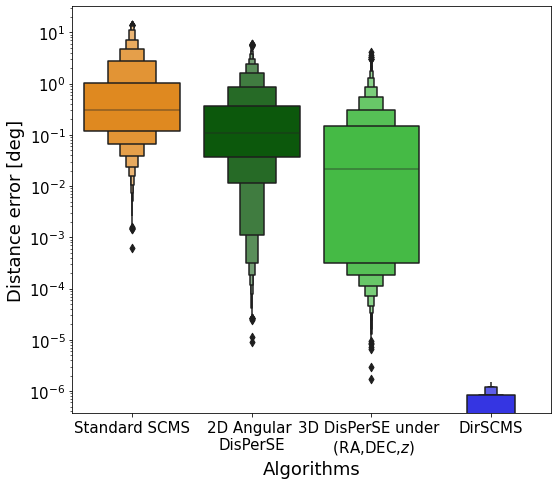

In [66]:
import seaborn as sns
fila_diff = pd.DataFrame({'Distance Error (degree)': 180*np.concatenate([Eu_diff, disp_ang_diff, 
                                                                         # disp_cart_diff, 
                                                                         disp_rs_diff, 
                                                                         Dir_diff])/np.pi, 
                          'Algorithms': np.concatenate([np.repeat('Standard SCMS', Eu_diff.shape[0]), 
                                                     np.repeat('2D Angular \nDisPerSE', disp_ang_diff.shape[0]),
                                                     # np.repeat('3D Cartesian \nDisPerSE on $\mathbb{S}^2$', disp_cart_diff.shape[0]),
                                                     np.repeat('3D DisPerSE under \n (RA,DEC,$z$)', disp_rs_diff.shape[0]),
                                                     np.repeat('DirSCMS', Dir_diff.shape[0])])})
plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
plt.figure(figsize=(8,7))

my_pal = {'Standard SCMS': 'darkorange', '2D Angular \nDisPerSE': 'darkgreen', 
          '3D DisPerSE under \n (RA,DEC,$z$)': 'limegreen', 'DirSCMS': 'blue'}
# sns.boxplot(y="Distance Error (degree)", x="Algorithms", data=fila_diff, palette=my_pal, boxprops=dict(alpha=.8))
sns.boxenplot(y="Distance Error (degree)", x="Algorithms", data=fila_diff, palette=my_pal)
plt.xlabel('Algorithms', fontsize=18)
plt.ylabel('Distance error [deg]', fontsize=18)
plt.yscale('log')
plt.tight_layout()
# plt.show()
plt.savefig('./Figures/disterr_compare_high_dec.pdf', bbox_inches="tight")

## Application II: Subset a slice of the Universe in the high-redshift region ($0.46 \leq z < 0.465$)

We subset the SDSS_IV galaxies on the North Galactic Cap within this redshift slice, obtain their spherical mean $\frac{\sum_{i=1}^n \mathbf{X}_i}{||\sum_{i=1}^n \mathbf{X}_i||_2}$ on the celestial sphere based on their (RAs, DECs), and rotate the galaxies such that their new spherical mean is at the North Pole ($DEC=90^{\circ}$).

**Notes: the python variables in our code below are mostly identical to the above "Application I". We only distinguish the output files through the redshift slice indicators "z_l, z_h". One should run our code with cautions.**

In [67]:
z_l = 0.46
z_h = 0.465
gal_slice = SDSS_dat[(SDSS_dat.Z >= z_l) & (SDSS_dat.Z < z_h)]
# Focus on the north galactic cap
gal_north = gal_slice[(gal_slice.RA > 100) & (gal_slice.RA < 270) & (gal_slice.DEC > -5) & (gal_slice.DEC < 70)]
X, Y, Z = sph2cart(*gal_north[['RA', 'DEC']].values.T)
gal_north_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
print(gal_north_cart.shape)

(14486, 3)


Prepare the data format of which the DisPerSE code can read: http://www2.iap.fr/users/sousbie/web/html/index744c.html?post/survey_ascii-format

In [68]:
from astropy.io import ascii

gal_north_ang = gal_north[['RA', 'DEC']]
gal_north_ang.columns = ['px', 'py']
dat_table = Table.from_pandas(gal_north_ang)

# Output the file for which the DisPerSE code can read: 2D angular coordinates indicated by columns 'px', 'py'.
ascii.write(dat_table, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046.survey_ascii', 
            overwrite=True, comment=False)

gal_north_cart_df = pd.DataFrame(gal_north_cart)
gal_north_cart_df.columns = ['px', 'py', 'pz']
dat_df = Table.from_pandas(gal_north_cart_df)

ascii.write(dat_df, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.survey_ascii', 
            overwrite=True, comment=False)


gal_north_rs = gal_north[['RA', 'DEC', 'Z']]
gal_north_rs.columns = ['ra', 'dec', 'z']
dat_table_rs = Table.from_pandas(gal_north_rs)

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.survey_ascii', 
            overwrite=True, comment=False)

In [69]:
## Compute the spherical mean
gal_c = np.sum(gal_north_cart, axis=0)/LA.norm(np.sum(gal_north_cart, axis=0))
RA_c, DEC_c, R = cart2sph(*gal_c.T)
RA_c + 360, DEC_c

(182.1029696929763, 35.65448655833855)

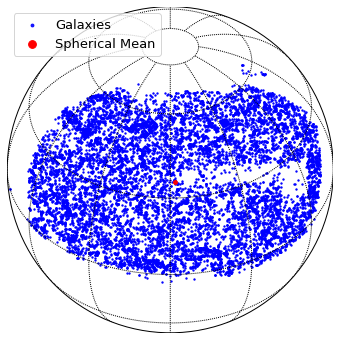

In [70]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_p = gal_north['RA']
lat_p = gal_north['DEC']
m1 = Basemap(projection='ortho', lon_0=180, lat_0=40, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_c, y_c = m1(RA_c+360, DEC_c)
cs = m1.scatter(x_p, y_p, color='blue', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_c, y_c, color='red', marker='o', s=15, label='Spherical Mean')
plt.legend(markerscale=2, loc='upper left')
# fig.tight_layout()
plt.show()

### Detecting the cosmic filaments before rotating the selected galaxies (i.e., in the original SDSS observational region with low declination)

#### (i) Standard SCMS and DirSCMS algorithms

In [71]:
# Bandwidth selection
data = gal_north_cart
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4

data = gal_north[['RA', 'DEC']].values
d = data.shape[1]
n = data.shape[0]
bw_Eu = 0.6*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))

# Thresholding
d_Eu_dat = KDE(gal_north[['RA', 'DEC']].values, gal_north[['RA', 'DEC']].values, h=bw_Eu)
tau = np.std(d_Eu_dat)
gal_north_ang = gal_north[['RA', 'DEC']].values
gal_north_ang_thres = gal_north_ang[d_Eu_dat >= tau,:]
gal_north_ang_thres = gal_north_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
print("Euclidean Thresholding Ratio: "+str(gal_north_ang_thres.shape[0]/gal_north_ang.shape[0]))

d_Dir_dat = DirKDE(gal_north_cart, gal_north_cart, h=bw_Dir)
gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.std(d_Dir_dat)]
gal_north_cart_thres = gal_north_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_north_cart_thres.shape[0]/gal_north_cart.shape[0]))

Euclidean Thresholding Ratio: 0.8000138064337982
Directional Thresholding Ratio: 0.8000138064337982


In [72]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)
mesh1_Eu = np.concatenate([lon_m.reshape(-1,1), lat_m.reshape(-1,1)], axis=1)

d_m_Dir = DirKDE(mesh1, gal_north_cart_thres, h=bw_Dir)
mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))

d_m_Eu = KDE(mesh1_Eu, gal_north_ang_thres, h=bw_Eu)
mesh1_Eu_thres = mesh1_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_Eu_thres.shape[0]/mesh1_Eu.shape[0]))

Remaining mesh point ratio: 0.8499538319482918
Remaining mesh point ratio: 0.8499538319482918


In [75]:
# DMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-15 04:48:59,612	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [76]:
# MS
ray.init()
mesh_0 = mesh1_Eu_thres
dataset = gal_north_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-7, max_iter=5000))
EuMS_pts = ray.get(result_ids)
EuMS_pts = np.concatenate(EuMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org_h0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuMS_pts], file)

2022-07-15 04:49:54,257	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [77]:
# DirSCMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_north_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                            eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-15 04:55:38,101	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [78]:
# SCMS
ray.init()
mesh_0 = mesh1_Eu_thres
dataset = gal_north_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                         eps=1e-7, max_iter=5000))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_org_h0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuSCMS_pts], file)

2022-07-15 05:03:15,221	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


#### (ii) Run the DisPerSE code on the 2D angular coordinates of $\mathbb{S}^2$

In [79]:
!../../disperse/bin/delaunay_2D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046 -btype smooth


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.0277458 (actual size is ~4.56431).
Tesselating 14486 particles (2D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.01s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (112 guards):  tesselation ...  generating ... cleaning up ... done. (+994 particles)
Adding 994 particles ... done.
Computing density ... done.
All done in 0.03 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046.NDnet
   comment: 'No cosmological conversion.'
   2D-Network has 14061 vertices.
   periodicity: non-periodic.
   Available faces: 41894 1-F, 27833 2-F.
   Bounding box: x0=[99.9162,-3.79984],
                 delta=[164.505,73.3805].
   Available fields: 'fi

In [80]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046 -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046.NDnet'.
Loading 2D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046.NDnet" ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (351 1-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 83788 cells:
   Identifying (1,2)-cell pairs:
      Sorting 41894 1-cells (asc.) ... done.
      Computing MST ... (components) done.(501/27833 comp.)
      Computing discrete Gradient (501 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Computing MST ... (components) done.(2411/14061 comp.)
      Computing discrete Gradient (2411 comp.) ... done.
   Critical cells : 2411(+0) 0-cells, 2910(+2910) 1-cells, 501(+0) 2-cells.
Computing discrete Morse-Smale complex: 
    5822 critical points: 501 min, 2910 s1, 2411 max.
    * 

In [81]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.NDskl'.
Loading 2D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 650(+93) nodes and 5282(-785) segments.
Assembling skeleton ... done. (found 195 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 314(-336) nodes and 5282(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 2D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iii) Run the DisPerSE code under the Cartesian coordinates on $\mathbb{S}^2$

In [82]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart -btype mirror


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.131796 (actual size is ~0.254346).
Tesselating 14486 particles (3D) ... (+18708 in boundary)
         Some points have identical coordinates !
 done. (0.28s elapsed)
Identifying boundaries ... done.
Adding 55826 guard particles ... 
         Some points have identical coordinates !
 done. (1.20s elapsed)
Identifying boundaries ... done.
Adding 331659 guard particles ... 
         Some points have identical coordinates !
 done. (4.64s elapsed)
Identifying boundaries ... done.
Computing density ... done.
All done in 5.28 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 41931 vertices.
   periodicity: non-periodic.
   Available faces

In [83]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (28730 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 857816 cells:
   Identifying (2,3)-cell pairs:
      Sorting 397089 2-cells (asc.) ... done.
      Computing MST ... (components) done.(613/167219 comp.)
      Computing discrete Gradient (613 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 251577 1-cells (desc.) ... done.
      Computing MST ... (components) done.(2204/41931 comp.)
      Computing discrete Gradient (2204 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ...

In [84]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 3809(+-632) nodes and 11644(-2884) segments.
Assembling skeleton ... done. (found 1033 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 1676(-2133) nodes and 11644(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iv) Run the DisPerSE code on the 3D (ra, dec, redshift) space under the WMAP-9 cosmology

In [85]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.131754 (actual size is ~456.384).
Tesselating 14486 particles (3D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.08s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (258 guards):  tesselation ...  generating ... cleaning up ... done. (+702628 particles)
Adding 702628 particles ... done.
Computing density ... done.
All done in 7.73 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 43076 vertices.
   periodicity: non-periodic.
   Available faces: 275682 1-F, 437476 2-F, 175752 3-

In [86]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs -periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (28868 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 931986 cells:
   Identifying (2,3)-cell pairs:
      Sorting 437476 2-cells (asc.) ... done.
      Computing MST ... (components) done.(2552/175752 comp.)
      Computing discrete Gradient (2552 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 275682 1-cells (desc.) ... done.
      Computing MST ... (components) done.(4818/43076 comp.)
      Computing discrete Gradient (4818 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ... d

In [87]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up \
-smooth 5 -breakdown -assemble 45 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 7204(+-54) nodes and 23752(-9776) segments.
Assembling skeleton ... done. (found 3330 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 3414(-3790) nodes and 23252(-500) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


### Detecting the cosmic filaments after rotating the selected galaxies to the regions with high declination (i.e., centering at the North pole)

In [88]:
## Compute the spherical mean
gal_c = np.sum(gal_north_cart, axis=0)/LA.norm(np.sum(gal_north_cart, axis=0))
RA_c, DEC_c, R = cart2sph(*gal_c.T)
RA_c + 360, DEC_c

(182.1029696929763, 35.65448655833855)

In [89]:
## Rotate the data samples accordingly
pv_ax = np.array([[0,0,1]])
gal_c = gal_c.reshape(1, 3)
R_mat = 2*np.dot(pv_ax.T + gal_c.T, pv_ax + gal_c)/np.sum((gal_c+pv_ax)**2, axis=1) - np.identity(3)
gal_north_rot = np.dot(R_mat, gal_north_cart.T).T
RA_r, DEC_r, R = cart2sph(*gal_north_rot.T)
RA_r[(RA_r >= -180) & (RA_r <= 0)] = RA_r[(RA_r >= -180) & (RA_r <= 0)] + 360
gal_north_rot_ang = np.concatenate([RA_r.reshape(-1,1), DEC_r.reshape(-1,1)], axis=1)

gal_north_rot_df = pd.DataFrame({'ra': RA_r, 'dec': DEC_r, 'z': gal_north.Z.values})

In [90]:
# Output the data after rotation
gal_north_rot_df[['px', 'py']] = gal_north_rot_df[['ra', 'dec']]
dat_table = Table.from_pandas(gal_north_rot_df[['px', 'py']])

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.survey_ascii', 
            overwrite=True, comment=False)

gal_north_rot_cart_df = pd.DataFrame(gal_north_rot)
gal_north_rot_cart_df.columns = ['px', 'py', 'pz']
dat_table_cart = Table.from_pandas(gal_north_rot_cart_df)

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_cart, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.survey_ascii', 
            overwrite=True, comment=False)

dat_table_rs = Table.from_pandas(gal_north_rot_df[['ra', 'dec', 'z']])

# Output the file for which the DisPerSE code can read.
ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.survey_ascii', 
            overwrite=True, comment=False)

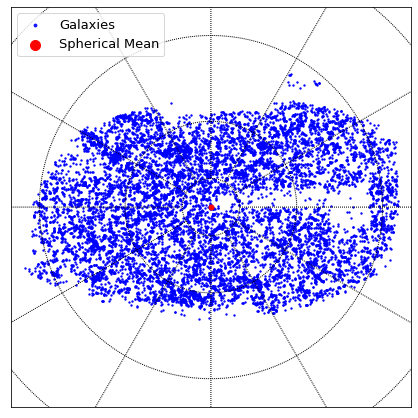

In [91]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_c, y_c = m1(0, 90)
cs = m1.scatter(x_p, y_p, color='blue', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_c, y_c, color='red', marker='o', s=25, label='Spherical Mean')
plt.legend(markerscale=2, loc='upper left')
fig.tight_layout()
plt.show()

#### (i) Standard SCMS and DirSCMS algorithms (at the North pole)

In [93]:
# Bandwidth selection (using the same choice of bandwidth parameter as the data are in low-DEC regions)
data = gal_north_rot
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4

data = gal_north_ang
d = data.shape[1]
n = data.shape[0]
bw_Eu = 0.6*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))

# Thresholding
d_Eu_dat = KDE(gal_north_rot_ang, gal_north_rot_ang, h=bw_Eu)
tau = np.std(d_Eu_dat)
gal_north_rot_ang_thres = gal_north_rot_ang[d_Eu_dat >= tau,:]
# if gal_north_rot_ang_thres.shape[0]/gal_north_rot_ang.shape[0] < 0.8:
gal_north_rot_ang_thres = gal_north_rot_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
print("Euclidean Thresholding Ratio: "+str(gal_north_rot_ang_thres.shape[0]/gal_north_rot_ang.shape[0]))

d_Dir_dat = DirKDE(gal_north_rot, gal_north_rot, h=bw_Dir)
rho_Dir = 1
gal_north_rot_thres = gal_north_rot[d_Dir_dat >= rho_Dir*np.std(d_Dir_dat)]
# if gal_north_rot_thres.shape[0]/gal_north_rot.shape[0] < 0.8:
gal_north_rot_thres = gal_north_rot[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_north_rot_thres.shape[0]/gal_north_rot.shape[0]))

Euclidean Thresholding Ratio: 0.8000138064337982
Directional Thresholding Ratio: 0.8000138064337982


In [94]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)
mesh1_rot = np.dot(R_mat, mesh1.T).T
lon_r, lat_r, R = cart2sph(*mesh1_rot.T)
lon_r[(lon_r >= -180) & (lon_r <= 0)] = lon_r[(lon_r >= -180) & (lon_r <= 0)] + 360
mesh1_rot_Eu = np.concatenate([lon_r.reshape(-1,1), lat_r.reshape(-1,1)], axis=1)

d_m_Dir = DirKDE(mesh1_rot, gal_north_rot_thres, h=bw_Dir)
mesh1_rot_thres = mesh1_rot[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_rot_thres.shape[0]/mesh1_rot.shape[0]))

d_m_Eu = KDE(mesh1_rot_Eu, gal_north_rot_ang_thres, h=bw_Eu)
mesh1_rot_Eu_thres = mesh1_rot_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_rot_Eu_thres.shape[0]/mesh1_rot_Eu.shape[0]))

Remaining mesh point ratio: 0.8499538319482918
Remaining mesh point ratio: 0.8499538319482918


In [97]:
# DMS
ray.init()
mesh_0 = mesh1_rot_thres
dataset = gal_north_rot_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-15 05:23:04,797	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [98]:
# MS
ray.init()
mesh_0 = mesh1_rot_Eu_thres
dataset = gal_north_rot_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-7, max_iter=5000))
EuMS_pts = ray.get(result_ids)
EuMS_pts = np.concatenate(EuMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuMS_pts], file)

2022-07-15 05:24:00,257	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [99]:
# DirSCMS
ray.init()
mesh_0 = mesh1_rot_thres
dataset = gal_north_rot_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                            eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-15 05:29:15,849	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [100]:
# SCMS
ray.init()
mesh_0 = mesh1_rot_Eu_thres
dataset = gal_north_rot_ang_thres
BW = bw_Eu
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                         eps=1e-7, max_iter=5000))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump([bw_Eu, EuSCMS_pts], file)

2022-07-15 05:36:41,686	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


#### (ii) Run the DisPerSE code on the 2D angular coordinates (at the North pole)

In [101]:
!../../disperse/bin/delaunay_2D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole -btype smooth


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.0200865 (actual size is ~7.24386).
Tesselating 14486 particles (2D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (128 guards):  tesselation ...  generating ... cleaning up ... done. (+1432 particles)
Adding 1432 particles ... done.
Computing density ... done.
All done in 0.03 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.NDnet
   comment: 'No cosmological conversion.'
   2D-Network has 14136 vertices.
   periodicity: non-periodic.
   Available faces: 42057 1-F, 27917 2-F.
   Bounding box: x0=[-0.273965,5.8654],
                 delta=[360.634

In [102]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.NDnet'.
Loading 2D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole.NDnet" ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (482 1-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 84110 cells:
   Identifying (1,2)-cell pairs:
      Sorting 42057 1-cells (asc.) ... done.
      Computing MST ... (components) done.(505/27917 comp.)
      Computing discrete Gradient (505 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Computing MST ... (components) done.(2547/14136 comp.)
      Computing discrete Gradient (2547 comp.) ... done.
   Critical cells : 2547(+0) 0-cells, 3051(+3051) 1-cells, 505(+0) 2-cells.
Computing discrete Morse-Smale complex: 
    6103 critical points: 505 min, 305

In [103]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.NDskl'.
Loading 2D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 675(+96) nodes and 5403(-827) segments.
Assembling skeleton ... done. (found 224 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 360(-315) nodes and 5403(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 2D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iii) Run the DisPerSE code under the Cartesian coordinates (at the North pole)

In [122]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart -btype mirror


reading ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.142722 (actual size is ~0.274259).
Tesselating 14486 particles (3D) ... (+18850 in boundary)
         Some points have identical coordinates !
 done. (0.37s elapsed)
Identifying boundaries ... done.
Adding 56062 guard particles ... 
         Some points have identical coordinates !
 done. (1.06s elapsed)
Identifying boundaries ... done.
Adding 251146 guard particles ... 
         Some points have identical coordinates !
 done. (3.47s elapsed)
Identifying boundaries ... done.
Computing density ... done.
All done in 3.95 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 41986 vertices.
   periodicity:

In [124]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (28248 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 886598 cells:
   Identifying (2,3)-cell pairs:
      Sorting 417596 2-cells (asc.) ... done.
      Computing MST ... (components) done.(377/167163 comp.)
      Computing discrete Gradient (377 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 259853 1-cells (desc.) ... done.
      Computing MST ... (components) done.(2219/41986 comp.)
      Computing discrete Gradient (2219 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computin

In [125]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up \
-smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 3535(+-614) nodes and 11422(-3035) segments.
Assembling skeleton ... done. (found 1032 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 1662(-1873) nodes and 11422(0) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl ... done.


#### (iv) Run the DisPerSE code on the 3D (ra, dec, redshift) space with WMAP-9 cosmology (at the North pole)

In [108]:
!../../disperse/bin/delaunay_3D .//Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.survey_ascii \
-outName .//Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading .//Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.survey_ascii (ASCII) ... done. (14486 lines)
Margin set to 0.142885 (actual size is ~492.787).
Tesselating 14486 particles (3D) ... (+0 in boundary) done. (0.08s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (236 guards):  tesselation ...  generating ... cleaning up ... done. (+709433 particles)
Adding 709433 particles ... done.
Computing density ... done.
All done in 7.92 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './/Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.NDnet'.
All done.

Network was saved as : .//Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 42125 vertices.
   periodicity: non-periodic.
   Available faces: 270318 1-F, 429782 2-F, 173484 3-F.
   Bounding 

In [109]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs \
-periodicity 0 -nsig 3 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (29305 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 915709 cells:
   Identifying (2,3)-cell pairs:
      Sorting 429782 2-cells (asc.) ... done.
      Computing MST ... (components) done.(2559/173484 comp.)
      Computing discrete Gradient (2559 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 270318 1-cells (desc.) ... done.
      Computing MST ... (components) done.(4961/42125 comp.)
      Computing discrete Gradient (4961 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing 

In [110]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up \
-smooth 5 -breakdown -assemble 45 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 7135(+-173) nodes and 23459(-9097) segments.
Assembling skeleton ... done. (found 3274 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 3352(-3783) nodes and 23109(-350) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


### Uncertainty measure with Nonparametric Bootstrap

In [111]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole.dat", "rb") as file:
    bw_Dir, DirModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/MS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuModes = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuFila = pickle.load(file)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

B = 100  ## Number of bootstrapping times
start = time.time()
np.random.seed(123) 
boot_fila_Dir = []
boot_fila_Eu = []
for b in range(B):
    # Bootstrap
    rand_ind = np.random.choice(range(gal_north_rot.shape[0]), gal_north_rot.shape[0], replace=True)
    boot_dat_cart = gal_north_rot[rand_ind]
    boot_dat_ang = gal_north_rot_ang[rand_ind]
    
    # Bandwidth selection
    print(bw_Dir)
    print(bw_Eu)
    
    # Thresholding
    d_Eu_dat = KDE(boot_dat_ang, boot_dat_ang, h=bw_Eu)
    tau = np.std(d_Eu_dat)
    boot_dat_ang_thres = boot_dat_ang[d_Eu_dat >= tau,:]
    # if boot_dat_ang_thres.shape[0]/boot_dat_ang.shape[0] < 0.8:
    boot_dat_ang_thres = boot_dat_ang[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
    print("Euclidean Thresholding Ratio: "+str(boot_dat_ang_thres.shape[0]/boot_dat_ang.shape[0]))
    
    d_Dir_dat = DirKDE(boot_dat_cart, boot_dat_cart, h=bw_Dir)
    boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.std(d_Dir_dat)]
    # if boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0] < 0.8:
    boot_dat_cart_thres = boot_dat_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
    print("Directional Thresholding Ratio: "+str(boot_dat_cart_thres.shape[0]/boot_dat_cart.shape[0]))
    
    nrows, ncols = (76, 171)
    lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    
    mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                            yg.reshape(nrows*ncols, 1),
                            zg.reshape(nrows*ncols, 1)), axis=1)
    mesh1_rot = np.dot(R_mat, mesh1.T).T
    lon_r, lat_r, R = cart2sph(*mesh1_rot.T)
    lon_r[(lon_r >= -180) & (lon_r <= 0)] = lon_r[(lon_r >= -180) & (lon_r <= 0)] + 360
    mesh1_rot_Eu = np.concatenate([lon_r.reshape(-1,1), lat_r.reshape(-1,1)], axis=1)

    d_m_Dir = DirKDE(mesh1_rot, boot_dat_cart_thres, h=bw_Dir)
    mesh1_rot_thres = mesh1_rot[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_rot_thres.shape[0]/mesh1_rot.shape[0]))
    
    d_m_Eu = KDE(mesh1_rot_Eu, boot_dat_ang_thres, h=bw_Eu)
    mesh1_rot_Eu_thres = mesh1_rot_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_rot_Eu_thres.shape[0]/mesh1_rot_Eu.shape[0]))
    
    # DirSCMS
    ray.init()
    mesh_0 = mesh1_rot_thres
    dataset = boot_dat_cart_thres
    BW = bw_Dir
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                                eps=1e-7, max_iter=5000))
    DirSCMS_pts = ray.get(result_ids)
    DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
    # ray.shutdown()
    boot_fila_Dir.append(DirSCMS_pts)
    
    # SCMS
    mesh_0 = mesh1_rot_Eu_thres
    dataset = boot_dat_ang_thres
    BW = bw_Eu
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(SCMS_Log_KDE_Fs.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, eps=1e-7, max_iter=5000))
    EuSCMS_pts = ray.get(result_ids)
    EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
    ray.shutdown()
    boot_fila_Eu.append(EuSCMS_pts)

with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "wb") as file:
    pickle.dump(boot_fila_Dir, file)
with open("./Data_Outputs/SDSS_Data/Boot_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "wb") as file:
    pickle.dump(boot_fila_Eu, file)
              
print("Elasped time: "+ str(time.time()-start)+'s.\n')

In [112]:
B = 100
with open("./Data_Outputs/SDSS_Data/Boot_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "rb") as file:
    boot_fila_Dir = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Boot_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_B"+str(B)+".dat", "rb") as file:
    boot_fila_Eu = pickle.load(file)

In [113]:
@ray.remote
def UncMsDir_Fs(fila, boot_fila):
    unc_arr = np.zeros((fila.shape[0], ))
    for i in range(fila.shape[0]):
        pt = fila[i,:]
        dist_sq = np.zeros((len(boot_fila), ))
        for j in range(len(boot_fila)):
            cir_inner = np.dot(boot_fila[j], pt)
            cir_inner[cir_inner > 1] = 1
            cir_inner[cir_inner < -1] = -1
            dist_sq[j] = min(np.arccos(cir_inner)**2)
        unc_arr[i] = np.sqrt(np.mean(dist_sq))
    return unc_arr

@ray.remote
def UncMsEu_Fs(fila, boot_fila):
    unc_arr = np.zeros((fila.shape[0], ))
    for i in range(fila.shape[0]):
        pt = fila[i,:]
        dist_sq = np.zeros((len(boot_fila), ))
        for j in range(len(boot_fila)):
            dist_sq[j] = min(LA.norm(boot_fila[j] - pt, axis=1)**2)
        unc_arr[i] = np.sqrt(np.mean(dist_sq))
    return unc_arr

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

ray.init()
chunksize = 10
fila_data = DirFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsDir_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Dir))
unc_Dir = ray.get(result_ids)
unc_Dir = np.concatenate(unc_Dir, axis=0)
ray.shutdown()

ray.init()
chunksize = 10
fila_data = EuFila
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(UncMsEu_Fs.remote(fila_data[i:(i+chunksize)], boot_fila=boot_fila_Eu))
unc_Eu = ray.get(result_ids)
unc_Eu = np.concatenate(unc_Eu, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "wb") as file:
    pickle.dump(unc_Dir, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "wb") as file:
    pickle.dump(unc_Eu, file)

In [114]:
with open("./Data_Outputs/SDSS_Data/Unc_Measure_DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    unc_Dir = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    unc_Eu = pickle.load(file)

In [126]:
import healpy as hp

def Mask_Filter(gal_RAs, gal_DECs, fil_RAs, fil_DECs, threshold=10, n_neigh=2, final_nside=256):
    nside = 32
    ## hp.nside2npix(nside) is equal to 12*nside**2
    healpix = np.zeros(hp.nside2npix(nside))
    gal_pix = hp.ang2pix(nside, theta=gal_RAs, phi=gal_DECs, lonlat=True)
    pix_ind, obs_cnt = np.unique(gal_pix, return_counts=True)
    healpix[pix_ind] = obs_cnt
    isolon, isolat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))[healpix > threshold], lonlat=True)
    
    # Set up the pixels and find their neighbors after thresholding
    nside_ne = 128
    healpix_ne = np.zeros(hp.nside2npix(nside_ne))
    ne_pix = hp.ang2pix(nside_ne, theta=isolon, phi=isolat, lonlat=True)
    for _ in range(n_neigh):
        ne_pix = np.unique(hp.get_all_neighbours(nside_ne, ne_pix))
    healpix_ne[ne_pix] = 1.
    healpix_ne = hp.ud_grade(healpix_ne, final_nside)
    
    fila_pix = hp.ang2pix(final_nside, theta=fil_RAs, phi=fil_DECs, lonlat=True)
    return healpix_ne, fila_pix

In [115]:
lon_f, lat_f, R = cart2sph(*DirFila.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], gal_DECs=gal_north_rot_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=1, 
                                        n_neigh=1, final_nside=32)
DirFila1 = DirFila[mask_pix_Dir[fil_pix_Dir] != 0]
unc_Dir1 = unc_Dir[mask_pix_Dir[fil_pix_Dir] != 0]

lon_m, lat_m, R = cart2sph(*DirModes.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)
DirModes1 = DirModes[mask_pix_Dir[mode_pix_Dir] != 0]

mask_pix_Eu, fil_pix_Eu = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], gal_DECs=gal_north_rot_ang[:,1], 
                                      fil_RAs=360-EuFila[:,0], fil_DECs=EuFila[:,1], 
                                      threshold=1, n_neigh=1, final_nside=32)
EuFila1 = EuFila[mask_pix_Eu[fil_pix_Eu] != 0]
unc_Eu1 = unc_Eu[mask_pix_Eu[fil_pix_Eu] != 0]

mode_pix_Eu = hp.ang2pix(32, theta=360-EuModes[:,0], phi=EuModes[:,1], lonlat=True)
EuModes1 = EuModes[mask_pix_Eu[mode_pix_Eu] != 0]

In [116]:
Knot_lab_Dir = pd.DataFrame(DirFila1).apply(lambda x: DetectKnot(x, r_in=2*bw_Dir/3, r_out=4*bw_Dir/3, 
                                                                fila_map=DirFila1), axis=1)
Knot_lab_Eu = pd.DataFrame(EuFila1).apply(lambda x: DetectKnot(x, r_in=2*bw_Eu/3, r_out=4*bw_Eu/3, 
                                                                fila_map=EuFila1), axis=1)

lon_c = np.linspace(0, 360, 200)
lat_c = 65*np.ones(200,)

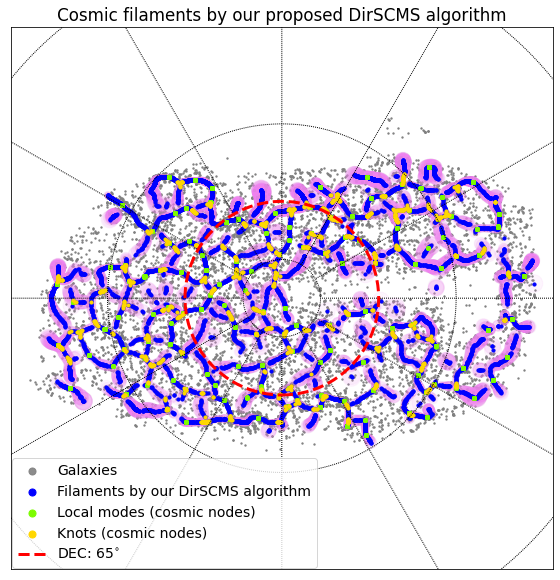

In [117]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))

# Subsample the galaxies and filamentary points for a lower resolution figure
np.random.seed(123)

lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes1.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila1.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='violet', s=(8e3)*unc_Dir1, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='blue', marker='o', s=10, label='Filaments by our DirSCMS algorithm')
# cs = m1.scatter(x_f, y_f, c=unc_Dir1*180/np.pi, s=8, cmap='winter')
cs = m1.scatter(x_m, y_m, color='lawngreen', marker='o', s=13, label='Local modes (cosmic nodes)')
cs = m1.scatter(x_f[Knot_lab_Dir == 'Knot'], y_f[Knot_lab_Dir == 'Knot'], color='gold', 
                marker='o', s=10, label='Knots (cosmic nodes)')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by our proposed DirSCMS algorithm')
plt.savefig('./Figures/DirSCMS_high_dec_high_rs.jpg', bbox_inches="tight", dpi=150)
# plt.show()

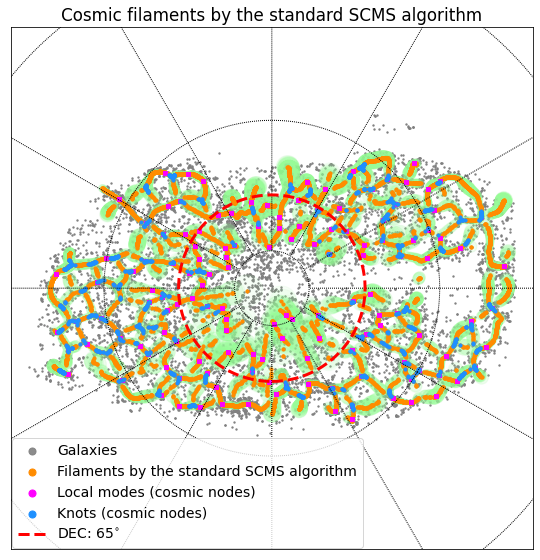

In [118]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_m = EuModes1[:,0]
lat_m = EuModes1[:,1]
lon_f = EuFila1[:,0]
lat_f = EuFila1[:,1]
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
## Color: 'lemonchiffon', 'peru', 'green', 'turquoise'
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='palegreen', s=(8e3)*unc_Eu1/180*np.pi, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='darkorange', marker='o', s=10, label='Filaments by the standard SCMS algorithm')
cs = m1.scatter(x_m, y_m, color='magenta', marker='o', s=16, label='Local modes (cosmic nodes)')
cs = m1.scatter(x_f[Knot_lab_Eu == 'Knot'], y_f[Knot_lab_Eu == 'Knot'], color='dodgerblue', 
                marker='o', s=10, label='Knots (cosmic nodes)')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
plt.title('Cosmic filaments by the standard SCMS algorithm')
plt.tight_layout()
plt.savefig('./Figures/EuSCMS_high_dec_high_rs.jpg', bbox_inches="tight", dpi=150)
# plt.show()

In [121]:
def read_skl(file, dim=3):
    i = 3
    line = 'start'
    while line != '[FILAMENTS]':
        line = np.loadtxt(file, skiprows=i, max_rows=1, usecols=0, dtype=str)
        i += 1
        
    n_fil = int(np.loadtxt(file, skiprows=i, max_rows=1, dtype=int))
    
    fil_id = np.zeros(0, dtype=int)
    fil_tracers = np.empty(shape=(0,dim), dtype=float)
    count = 1
    for j in range(n_fil):
        n_tracers = int(np.loadtxt(file, skiprows=i+1, max_rows=1, usecols=2, dtype=int))
        filament = np.loadtxt(file, skiprows=i+2, max_rows=n_tracers)
        fil_tracers = np.vstack([fil_tracers, filament])
        fil_id = np.append(fil_id, count*np.ones(n_tracers, dtype=int))
        count += 1
        i += n_tracers + 1
    
    return(n_fil, fil_id, fil_tracers)

In [ ]:
### Warnings: this chunk of code takes several hours to execute!! One can choose to 
### load our pre-computed results instead.

import os
disp_fil, fil_id, disp_web_rot = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
disp_fil, fil_id, disp_web_rot3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)

np.random.seed(123)
B = 100
unc_ang = np.zeros((B, disp_web_rot.shape[0]))
unc_3D = np.zeros((B, disp_web_rot3D.shape[0]))
unc_cart = np.zeros((B, disp_web_rot_cart.shape[0]))
for b in range(B):
    print(b)
    # Bootstrap
    rand_ind = np.random.choice(range(gal_north_rot.shape[0]), gal_north_rot.shape[0], replace=True)
    boot_dat_cart = gal_north_rot[rand_ind]
    boot_dat_ang = gal_north_rot_ang[rand_ind]
    boot_dat_rs = gal_north_rot_df.iloc[rand_ind].reset_index()
    
    dat_ang = pd.DataFrame(boot_dat_ang)
    dat_ang.columns = ['px', 'py']
    dat_ang = Table.from_pandas(dat_ang)

    # Output the file for which the DisPerSE code can read.
    ascii.write(dat_ang, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'.survey_ascii', overwrite=True, comment=False)
    
    dat_cart = pd.DataFrame(boot_dat_cart)
    dat_cart.columns = ['px', 'py', 'pz']
    dat_cart = Table.from_pandas(dat_cart)
    ascii.write(dat_cart, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart.survey_ascii', overwrite=True, comment=False)
    
    dat_table_rs = Table.from_pandas(boot_dat_rs[['ra', 'dec', 'z']])
    ascii.write(dat_table_rs, './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs.survey_ascii', 
            overwrite=True, comment=False)
    
    # 2D Angular (ra,dec) coordinate on S^2 
    os.system('../../disperse/bin/delaunay_2D '\
              './Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+' -btype smooth')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+\
              ' -periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_s3.up '\
              '-smooth 5 -breakdown -assemble 75 -to NDskl_ascii')
    
    # 3D Cartesian coordinate on S^2
    os.system('../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart -btype mirror')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart '\
              '-periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_cart_s3.up '\
              '-smooth 5 -breakdown -assemble 75 -to NDskl_ascii')
    
    # 3D (ra,dec,z) coordinate
    os.system('../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs.survey_ascii '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs '\
              '-btype smooth -cosmo 0.286 0.714 0.00 0.693 -1.00')
    
    os.system('../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs.NDnet '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs '\
              '-periodicity 0 -nsig 3 -forceLoops -upSkl')
    
    os.system('../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs_s3.up.NDskl '\
              '-outName ./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+'_rs_s3.up '\
              '-smooth 5 -breakdown -assemble 45 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii')
    
    
    disp_fil, fil_id, disp_ang_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+\
                                               '_s3.up.S005.BRK.ASMB.a.NDskl', dim=2)
    for i in range(disp_web_rot.shape[0]):
        unc_ang[b,i] = min(LA.norm(disp_ang_boot - disp_web_rot[i,:], axis=1)**2)
    
    disp_fil, fil_id, disp_cart_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+\
                                                '_cart_s3.up.S005.BRK.ASMB.a.NDskl', dim=3)
    inn_prod = np.dot(disp_web_rot_cart, disp_cart_boot.T)
    inn_prod[inn_prod > 1] = 1
    inn_prod[inn_prod < -1] = -1
    unc_cart[b,:] = np.min(np.arccos(inn_prod)**2, axis=1)
    
    disp_fil, fil_id, disp_3Drs_boot = read_skl('./Data_Outputs/Disperse_IO_files/Bootstrap_outputs/SDSS_gal_z046_B'+str(b)+\
                                                '_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', dim=3)
    for i in range(disp_web_rot3D.shape[0]):
        unc_3D[b,i] = min(LA.norm(disp_3Drs_boot[:,:2] - disp_web_rot3D[i,:2], axis=1)**2)
    
unc_ang1 = np.sqrt(np.mean(unc_ang, axis=0))
unc_cart1 = np.sqrt(np.mean(unc_cart, axis=0))
unc_3D1 = np.sqrt(np.mean(unc_3D, axis=0))

with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"ang_north_pole.dat", "wb") as file:
    pickle.dump(unc_ang1, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"cart_north_pole.dat", "wb") as file:
    pickle.dump(unc_cart1, file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"rs_north_pole.dat", "wb") as file:
    pickle.dump(unc_3D1, file)

In [127]:
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"ang_north_pole.dat", "rb") as file:
    unc_ang1 = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"cart_north_pole.dat", "rb") as file:
    unc_cart1 = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/Unc_Measure_disperse_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"rs_north_pole.dat", "rb") as file:
    unc_3D1 = pickle.load(file)

In [128]:
disp_fil, fil_id, disp_web_rot = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
dis_fila_rot = pd.DataFrame(disp_web_rot)
dis_fila_rot.columns = ['RA', 'DEC']

disp_fil, fil_id, disp_web_rot3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
dis_fila_rot_3D = pd.DataFrame(disp_web_rot3D)
dis_fila_rot_3D.columns = ['RA', 'DEC', 'Z']

disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)
lon_f, lat_f, R = cart2sph(*disp_web_rot_cart.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
dis_fila_rot_cart = pd.DataFrame({'RA': lon_f, 'DEC': lat_f})

In [129]:
mask_pix_disp_rot, fil_pix_disp_rot = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                  gal_DECs=gal_north_rot_ang[:,1], 
                                                  fil_RAs=360-dis_fila_rot['RA'].values, 
                                                  fil_DECs=dis_fila_rot['DEC'].values, 
                                                  threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot = dis_fila_rot[mask_pix_disp_rot[fil_pix_disp_rot] != 0]
unc_ang2 = unc_ang1[mask_pix_disp_rot[fil_pix_disp_rot] != 0]

mask_pix_disp_rot_3D, fil_pix_disp_rot_3D = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                      gal_DECs=gal_north_rot_ang[:,1], 
                                                      fil_RAs=360-dis_fila_rot_3D['RA'].values, 
                                                      fil_DECs=dis_fila_rot_3D['DEC'].values, 
                                                      threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot_3D = dis_fila_rot_3D[mask_pix_disp_rot_3D[fil_pix_disp_rot_3D] != 0]
unc_3D2 = unc_3D1[mask_pix_disp_rot_3D[fil_pix_disp_rot_3D] != 0]

mask_pix_disp_rot_cart, fil_pix_disp_rot_cart = Mask_Filter(gal_RAs=360-gal_north_rot_ang[:,0], 
                                                      gal_DECs=gal_north_rot_ang[:,1], 
                                                      fil_RAs=360-dis_fila_rot_cart['RA'].values, 
                                                      fil_DECs=dis_fila_rot_cart['DEC'].values, 
                                                      threshold=2, n_neigh=1, final_nside=32)
dis_fila_rot_cart = dis_fila_rot_cart[mask_pix_disp_rot_cart[fil_pix_disp_rot_cart] != 0]
unc_cart2 = unc_cart1[mask_pix_disp_rot_cart[fil_pix_disp_rot_cart] != 0]

lon_c = np.linspace(0, 360, 200)
lat_c = 65*np.ones(200,)

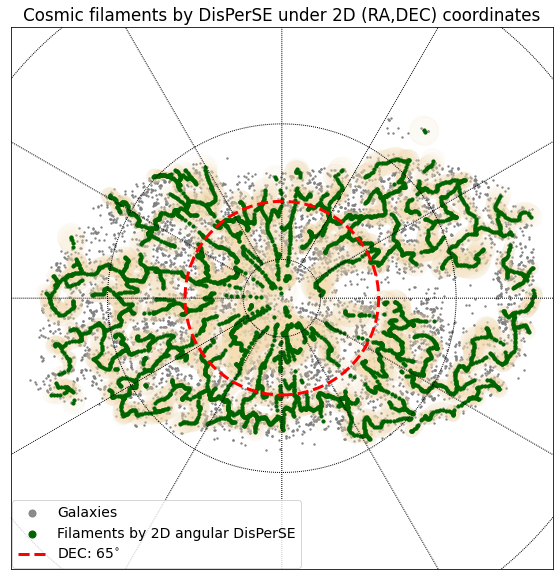

In [130]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_f = dis_fila_rot['RA'].values
lat_f = dis_fila_rot['DEC'].values
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='wheat', s=(8e3)*unc_ang2/180*np.pi, alpha=0.08)
cs = m1.scatter(x_f, y_f, color='darkgreen', marker='o', s=10, label='Filaments by 2D angular DisPerSE')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by DisPerSE under 2D (RA,DEC) coordinates')
plt.savefig('./Figures/Disperse_ang_high_dec_high_rs.jpg', bbox_inches="tight", dpi=150)
# plt.show()

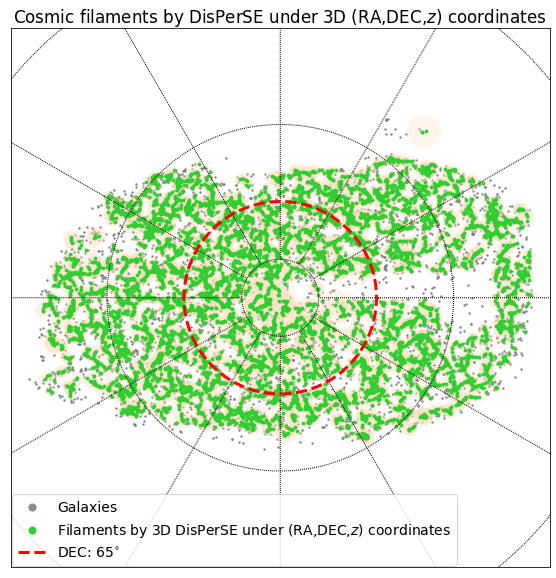

In [131]:
plt.rcParams.update({'font.size': 14})  ## Change the font sizes of ouput figures

np.random.seed(123)
f_ind = np.random.choice(range(dis_fila_rot_3D.shape[0]), 10000, replace=False)

fig = plt.figure(figsize=(8,8))
lon_p = gal_north_rot_ang[:,0]
lat_p = gal_north_rot_ang[:,1]
lon_f = dis_fila_rot_3D.iloc[f_ind]['RA'].values
lat_f = dis_fila_rot_3D.iloc[f_ind]['DEC'].values
m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
# m1 = Basemap(width=18000000,height=13000000, resolution='l',projection='stere', lat_ts=50,lat_0=30,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(0, 90, 45))
x_p, y_p = m1(lon_p, lat_p)
x_f, y_f = m1(lon_f, lat_f)
x_c, y_c = m1(lon_c, lat_c)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='bisque', s=(8e3)*unc_3D2[f_ind]/180*np.pi, alpha=0.2)
cs = m1.scatter(x_f, y_f, color='limegreen', marker='o', s=8, label='Filaments by 3D DisPerSE under (RA,DEC,$z$) coordinates')
cs = m1.plot(x_c, y_c, color='red', linestyle='dashed', linewidth=3, label='DEC: $65^{\circ}$')
lgnd = plt.legend(loc='lower left', numpoints=1, bbox_to_anchor=(-0.01, -0.01))
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
# plt.colorbar(label='Uncertainty measures for filaments (degree)')
plt.tight_layout()
plt.title('Cosmic filaments by DisPerSE under 3D (RA,DEC,$z$) coordinates')
plt.savefig('./Figures/Disperse_rs_high_dec_high_rs.jpg', bbox_inches="tight", dpi=150)
# plt.show()

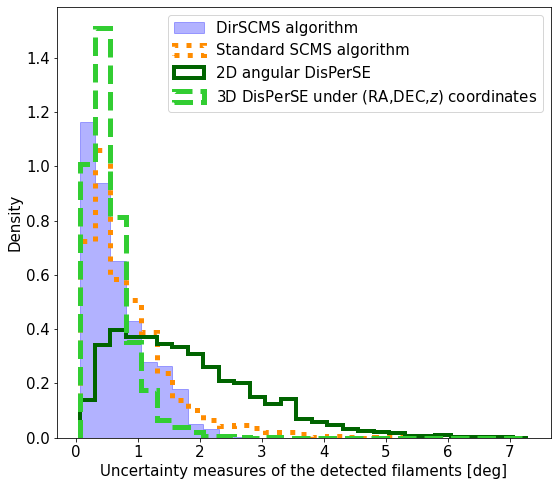

In [132]:
bins_ed = np.linspace(min(unc_Dir1*180/np.pi), max(unc_Eu1), 30)
alp = 1

plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
plt.figure(figsize=(8,7))
# Histogram comparisons
plt.hist(unc_Dir1*180/np.pi, bins=bins_ed, histtype='step', alpha=0.3, fill=True, density=True, color='blue',
         label='DirSCMS algorithm')
plt.hist(unc_Eu1, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='darkorange', 
         linewidth=5, linestyle='dotted', label='Standard SCMS algorithm')
plt.hist(unc_ang2, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='darkgreen', 
         linewidth=4, label='2D angular DisPerSE')
# plt.hist(unc_cart2*180/np.pi, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, 
#          label='3D Cartesian DisPerSE on $\mathbb{S}^2$')
plt.hist(unc_3D2, bins=bins_ed, histtype='step', alpha=alp, fill=False, density=True, color='limegreen',
         linewidth=5, linestyle='dashed', label='3D DisPerSE under (RA,DEC,$z$) coordinates')
plt.legend()
plt.xlabel('Uncertainty measures of the detected filaments [deg]')
plt.ylabel('Density')
plt.tight_layout()
# plt.show()
plt.savefig('./Figures/Unc_compare_high_dec_high_rs.pdf', bbox_inches="tight")

### Comparing the detected filaments by different methods when the input galaxies are in low-DEC and high-DEC regions

In [133]:
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org.dat", "rb") as file:
    bw_Dir, DirFila_org = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_org_h0.6.dat", "rb") as file:
    bw_Eu, EuFila_org = pickle.load(file)
    
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole.dat", "rb") as file:
    bw_Dir, DirFila = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/SCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_north_pole_h_org0.6.dat", "rb") as file:
    bw_Eu, EuFila = pickle.load(file)

In [134]:
## Rotate the detected filaments from low-DEC regions to high-DEC ones accordingly
pv_ax = np.array([[0,0,1]])
gal_c = gal_c.reshape(1, 3)
R_mat = 2*np.dot(pv_ax.T + gal_c.T, pv_ax + gal_c)/np.sum((gal_c+pv_ax)**2, axis=1) - np.identity(3)
DirFila_org_rot = np.dot(R_mat, DirFila_org.T).T

X_f, Y_f, Z_f = sph2cart(*EuFila_org.T)
EuFila_org_cart = np.vstack((X_f, Y_f, Z_f)).T
EuFila_org_rot = np.dot(R_mat, EuFila_org_cart.T).T
# RA_f, DEC_f, R = cart2sph(*EuFila_rot.T)
# RA_f[(RA_f >= -180) & (RA_f <= 0)] = RA_f[(RA_f >= -180) & (RA_f <= 0)] + 360

X_f, Y_f, Z_f = sph2cart(*EuFila.T)
EuFila_cart = np.vstack((X_f, Y_f, Z_f)).T

In [135]:
disp_fil, fil_id, dis_fila_org = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_s3.up.S005.BRK.ASMB.a.NDskl', 
                                          dim=2)
X_f, Y_f, Z_f = sph2cart(*dis_fila_org.T)
dis_fila_org_cart = np.vstack((X_f, Y_f, Z_f)).T
dis_fila_org_rot = np.dot(R_mat, dis_fila_org_cart.T).T

disp_fil, fil_id, dis_fila_cart_org = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                          dim=3)
dis_fila_cart_rot = np.dot(R_mat, dis_fila_cart_org.T).T

disp_fil, fil_id, dis_fila_3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', dim=3)
X_f, Y_f, Z_f = sph2cart(*dis_fila_3D[:,:2].T)
dis_fila_3D_org = np.vstack((X_f, Y_f, Z_f)).T
dis_fila_3D_rot = np.dot(R_mat, dis_fila_3D_org.T).T

In [136]:
disp_fil, fil_id, disp_web_north = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_s3.up.S005.BRK.ASMB.a.NDskl', 
                                         dim=2)
X_f, Y_f, Z_f = sph2cart(*disp_web_north.T)
disp_web_north_cart = np.vstack((X_f, Y_f, Z_f)).T

disp_fil, fil_id, disp_web_north_3D = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_rs_s3.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                           dim=3)
X_f, Y_f, Z_f = sph2cart(*disp_web_north_3D[:,:2].T)
disp_web_north_3D = np.vstack((X_f, Y_f, Z_f)).T

disp_fil, fil_id, disp_web_rot_cart = read_skl('./Data_Outputs/Disperse_IO_files/SDSS_gal_z046_north_pole_cart_s3.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)

In [137]:
def DistToFila(x, tar_fila):
    x = x.values
    in_pd = np.dot(tar_fila, x)
    in_pd[in_pd > 1] = 1
    in_pd[in_pd < -1] = -1
    return min(np.arccos(in_pd))

Eu_diff = pd.DataFrame(EuFila_cart).apply(lambda x: DistToFila(x, tar_fila=EuFila_org_rot), axis=1)
Dir_diff = pd.DataFrame(DirFila).apply(lambda x: DistToFila(x, tar_fila=DirFila_org_rot), axis=1)
disp_ang_diff = pd.DataFrame(disp_web_north_cart).apply(lambda x: DistToFila(x, tar_fila=dis_fila_org_rot), axis=1)
disp_cart_diff = pd.DataFrame(disp_web_rot_cart).apply(lambda x: DistToFila(x, tar_fila=dis_fila_cart_rot), axis=1)
disp_rs_diff = pd.DataFrame(disp_web_north_3D).apply(lambda x: DistToFila(x, tar_fila=dis_fila_3D_rot), axis=1)

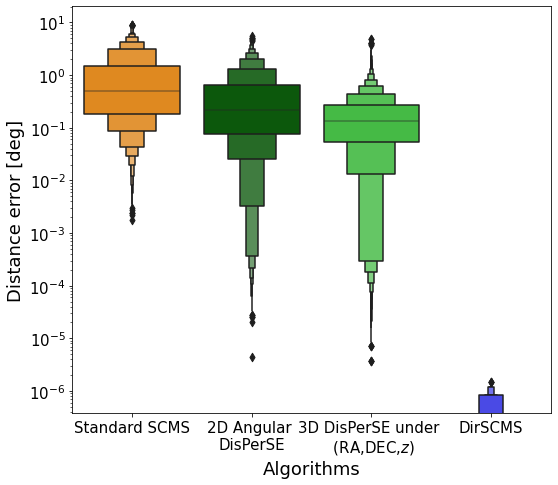

In [138]:
import seaborn as sns
fila_diff = pd.DataFrame({'Distance Error (degree)': 180*np.concatenate([Eu_diff, disp_ang_diff, 
                                                                         # disp_cart_diff, 
                                                                         disp_rs_diff, 
                                                                         Dir_diff])/np.pi, 
                          'Algorithms': np.concatenate([np.repeat('Standard SCMS', Eu_diff.shape[0]), 
                                                     np.repeat('2D Angular \nDisPerSE', disp_ang_diff.shape[0]),
                                                     # np.repeat('3D Cartesian \nDisPerSE on $\mathbb{S}^2$', disp_cart_diff.shape[0]),
                                                     np.repeat('3D DisPerSE under \n (RA,DEC,$z$)', disp_rs_diff.shape[0]),
                                                     np.repeat('DirSCMS', Dir_diff.shape[0])])})
plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
plt.figure(figsize=(8,7))

my_pal = {'Standard SCMS': 'darkorange', '2D Angular \nDisPerSE': 'darkgreen', 
          '3D DisPerSE under \n (RA,DEC,$z$)': 'limegreen', 'DirSCMS': 'blue'}
# sns.boxplot(y="Distance Error (degree)", x="Algorithms", data=fila_diff, palette=my_pal, boxprops=dict(alpha=.8))
sns.boxenplot(y="Distance Error (degree)", x="Algorithms", data=fila_diff, palette=my_pal)
plt.xlabel('Algorithms', fontsize=18)
plt.ylabel('Distance error [deg]', fontsize=18)
plt.yscale('log')
plt.tight_layout()
# plt.show()
plt.savefig('./Figures/disterr_compare_high_dec_high_rs.pdf', bbox_inches="tight")